# Analysis of the effect of ethnicity on food purchase in London's Tesco supermarkets

Study the impact of ethnic diversity on food purchase in London's Tesco

Use tesco dataset, extend it with LSOA atlas which gives us many socio-economic informations

Study correlations between the ethnic diversity data and product category data at several level of granularity
- does ethnic diversity favours diversity in purchased products
- how does specific ethnic groups correlate with diversity of purchased products
- how does specific ethnic groups correlate with specific food products

Try to find a causality relation between ethnicity and food purchase when taking other parameters that can act as confounder into acount
    simple linear regression
    generalized propensity matching
    
limitation of the tesco dataset to represent the overall food habits of the population. Study focus more on shopping habit at tesco since we can't assess more with high level of certitude

# changed

The goal of our study is to observe the impact of the ethnicity of Tesco's customer in London on the kind of alimentary products they purchase.
To achieve this, we will use the Tesco Grocery 1.0 dataset that report the food items purchased in London's Tesco supermarket and extend with the LSOA atlas, a dataset containing sensus data, which gives us information on the representation of different ethnic groups accross the city of London. 

We will first study the correlations between ethnicity and the type of products purchased at different level of granularity. We will look if ethnic diversity is linked to diversity in grocery purchase, if the various represented ethnic groups correlate diffently to the diversity in grocery purchase and how does the represented ethnic groups correlates with the different food product categories reported in the Tesco dataset.

After that, we will move forward and try to assess if the distribution of the different ethnic groups and their diversity has a causality relation on the viariation of the food purchases, when taking into account other socio-economic features reported in the LSOA atlas that could acte as confounders. We will first carry a simple linear regression analysis, followed by a propensity score matching analysis.

Before getting started it is worth to pay attention to one of the Tesco dataset limitations. The data reported being only issues from grocery purchases done at Tesco, it is not truely representative of the overall food habits of the London's inhabitants. To address this issue, the authors created a representativity feature from the number of the different customers and the total population of the area to get a sense of how much Tesco groceries purchases could explain the overall dietary habits. After trying to fiter our dataset to get a high level of representativity, we noticed that rejected too many areas of our dataset to allow the observations of significative relations. We hence decided to focus our study on shopping habbits rather than eating habbits to get results with high enough significance to be worth analysing.

## Table of contents

---

## 1. Set the environment and perform exploratory analysis

### Import the packages 

In [1]:
### Classic imports 

import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib

import os


### Imports for statistical analysis

import scipy
from scipy.stats import spearmanr

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split


### Imports for specific visualizations

import geopandas as gpd

import plotly
import plotly.express as px
import plotly.graph_objects as go


### Import associated to propensity score matching

from causal_curve import GPS


### Other imports

import re


---
# changed

## 2. Loading of the data

The data used for this study are issued from three different datasets:

In [2]:
GEO_LSOA_PATH = os.getcwd() + '/data/Geo_data/LSOA_2011_London_gen_MHW.shp'
TESCO_PATH = os.getcwd() + '/data/Area_level_data/year_lsoa_grocery.csv'
SOCIO_ECO_LSOA_PATH = os.getcwd() + '/data/lsoa-data.csv'

# changed

- **Tesco Grocery 1.0 dataset**: Record of food items purchased by fidelity card owners at Tesco stores in Greater london over the year 2015, aggregated at Lower super output area (LSOA) level. For each area, this dataset report properties (weight, nutrient composition) of the typical food item bought. All purchased items used to generate this dataset were also clustered into 17 non-overlapping product categories (e.g. red mead, dairy, fruit & vegetables, bottled water, beer, etc.). The probability distribution of items belonging to the 17 different product categories  is also reported for each area, as well as the entropy of this distribution, that serves as a measure of food products diversity.

In [3]:
tesco_df = pd.read_csv(TESCO_PATH)
tesco_df.sample(5)

area_id      weight  weight_perc2.5  weight_perc25  weight_perc50  \
3617  E01003702  357.813213            30.0          150.0          250.0   
2640  E01002702  345.855083            30.0          150.0          260.0   
3746  E01003832  349.398162            40.0          150.0          250.0   
171   E01000176  414.465431            40.0          180.0          330.0   
356   E01000362  356.815199            32.5          157.0          300.0   

      weight_perc75  weight_perc97.5  weight_std  weight_ci95      volume  \
3617          450.0           1000.0  413.370750     5.443837  106.376457   
2640          430.0           1000.0  390.447460     3.574646  115.698852   
3746          450.0           1000.0  446.158938    19.501910  103.602830   
171           500.0           1290.0  439.254566     1.777172  119.930928   
356           500.0           1000.0  349.212896     8.823227  106.671761   

      ...  man_day  population    male  female  age_0_17  age_18_64  age_65+  \
3617  ...     4938      1798.0   887.0   911.0     395.0     1182.0    221.0   
2640  ...    12436      2182.0  1121.0  1061.0     378.0     1663.0    141.0   
3746  ...      785      1495.0   702.0   793.0     326.0      952.0    217.0   
171   ...    30909      1651.0   802.0   849.0     327.0     1017.0    307.0   
356   ...     1770      1598.0   757.0   841.0     326.0      904.0    368.0   

        avg_age  area_sq_km  people_per_sq_km  
3617  36.577308        0.31            5800.0  
2640  31.069661        0.12           18859.0  
3746  39.352508        0.22            6719.0  
171   39.949122        0.22            7515.0  
356   43.082603        0.39            4052.0  

[5 rows x 202 columns]

# changed

- **LSOA atlas** (https://data.london.gov.uk/dataset/lsoa-atlas) an official summary of demographic data for the city of London for the year 2011, aggregated at LSOA level. This contains many socio-economic features of the the London's LSOA such as ethnic groups repartitions that we will use for our study

In [4]:
lsoa_df = pd.read_csv(SOCIO_ECO_LSOA_PATH, encoding = "ISO-8859-1", engine='python')
lsoa_df.sample(5)

Lower Super Output Area          Names  \
41                 E01000866    Camden 009A   
1147               E01003551    Newham 009A   
399                E01001975  Haringey 001D   
2464               E01000601     Brent 021B   
2047               E01000116    Barnet 009B   

      Mid-year Population Estimates;All Ages;2001  \
41                                         1772.0   
1147                                       1600.0   
399                                        1531.0   
2464                                       1433.0   
2047                                       1624.0   

      Mid-year Population Estimates;All Ages;2002  \
41                                         1844.0   
1147                                       1590.0   
399                                        1584.0   
2464                                       1407.0   
2047                                       1598.0   

      Mid-year Population Estimates;All Ages;2003  \
41                                         1793.0   
1147                                       1548.0   
399                                        1510.0   
2464                                       1406.0   
2047                                       1608.0   

      Mid-year Population Estimates;All Ages;2004  \
41                                         1897.0   
1147                                       1538.0   
399                                        1513.0   
2464                                       1430.0   
2047                                       1601.0   

      Mid-year Population Estimates;All Ages;2005  \
41                                         1983.0   
1147                                       1562.0   
399                                        1534.0   
2464                                       1448.0   
2047                                       1636.0   

      Mid-year Population Estimates;All Ages;2006  \
41                                         1971.0   
1147                                       1556.0   
399                                        1516.0   
2464                                       1469.0   
2047                                       1668.0   

      Mid-year Population Estimates;All Ages;2007  \
41                                         2045.0   
1147                                       1588.0   
399                                        1620.0   
2464                                       1485.0   
2047                                       1666.0   

      Mid-year Population Estimates;All Ages;2008  ...  \
41                                         1926.0  ...   
1147                                       1637.0  ...   
399                                        1620.0  ...   
2464                                       1483.0  ...   
2047                                       1663.0  ...   

      Road Casualties;2012;Slight  Road Casualties;2012;2012 Total  \
41                            2.0                              2.0   
1147                          3.0                              3.0   
399                           5.0                              7.0   
2464                         12.0                             12.0   
2047                          4.0                              4.0   

      Road Casualties;2013;Fatal  Road Casualties;2013;Serious  \
41                           0.0                           2.0   
1147                         0.0                           0.0   
399                          0.0                           1.0   
2464                         0.0                           0.0   
2047                         0.0                           0.0   

      Road Casualties;2013;Slight  Road Casualties;2013;2013 Total  \
41                            4.0                              6.0   
1147                         10.0                             10.0   
399                          12.0                             13.0   
2464                         14.0         

# changed

- **Geographical information dataset of the LSOA** (https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london): Range of key GIS boundary files for ESRI and Map Info covering Greater London. This dataset will be used for visualization purposes as it will allow to display some of the results on the London map with relevant values assigned to each geographical region representing the LSOA. 

In [5]:
map_df = gpd.read_file(GEO_LSOA_PATH)
map_df.sample(5)

LSOA11CD         LSOA11NM   MSOA11CD        MSOA11NM    LAD11CD  \
2293  E01002344    Havering 029B  E02000492    Havering 029  E09000016   
4496  E01004610  Wandsworth 033C  E02000955  Wandsworth 033  E09000032   
996   E01001015     Croydon 041A  E02000234     Croydon 041  E09000008   
2717  E01002782   Islington 012E  E02000565   Islington 012  E09000019   
3679  E01003764   Redbridge 009F  E02000759   Redbridge 009  E09000026   

         LAD11NM    RGN11CD RGN11NM  USUALRES  HHOLDRES  COMESTRES  POPDEN  \
2293    Havering  E12000007  London      1528      1524          4     1.5   
4496  Wandsworth  E12000007  London      1978      1976          2    69.1   
996      Croydon  E12000007  London      1440      1440          0    35.9   
2717   Islington  E12000007  London      1533      1533          0   174.0   
3679   Redbridge  E12000007  London      1962      1954          8    36.9   

      HHOLDS  AVHHOLDSZ                                           geometry  
2293     638        2.4  POLYGON ((553760.167 182564.065, 553735.690 18...  
4496     632        3.1  POLYGON ((527390.986 172203.511, 527532.832 17...  
996      515        2.8  POLYGON ((530071.310 159149.920, 530108.847 15...  
2717     616        2.5  POLYGON ((532838.985 185431.955, 532858.723 18...  
3679     835        2.3  POLYGON ((541002.619 190370.254, 541139.000 19...

---

## 3. Cleaning and filtering of the data

### 3.1. Cleaning and filtering of the Tesco dataset

First we need to filter the tesco dataset to keep only what is interesting to our study:

Since we are mainly interested in the food purchase diversity, we decide to keep only the columns reporting the proportions of the different item categories as well as their normalized entropy. The nutritive values is indeed of no use for our analysis.
We also decide to keep the last columns of the dataset that report different demographic informations about the LSOAs.

In [6]:
def filter_and_clean_tesco(tesco_df):
    """
    filter the tesco dataset by removing columns not useful for our study
    """
    
    filtered_df = tesco_df.loc[:, 'area_id']
    filtered_df = pd.concat([ filtered_df, tesco_df.loc[:, 'f_beer':'f_wine'] ], axis=1)
    filtered_df = pd.concat([ filtered_df, tesco_df.loc[:, 'h_items_norm'] ], axis=1)
    filtered_df = pd.concat([ filtered_df, tesco_df.loc[:, 'representativeness_norm':] ], axis=1)

    return filtered_df

print("Size before filtering:", tesco_df.shape)
filt_tesco_df = filter_and_clean_tesco(tesco_df)
print("After filtering:", filt_tesco_df.shape)

Size before filtering: (4833, 202)
After filtering: (4833, 32)


# changed

### 3.2 Cleaning and filtering of the LSOA atlas

We then also need to filter and clean the LSOA dataset:

We decide to drop some columns that report information already present in the tesco dataset:
- Population estimates
- Population ages
- Population density

We drop the road casualities data as well as they are irrelevant to our question of interest.

This dataset is composed mainly of socio-economic data from 2011, some of the columns however have also values for other years in addition. We decide to keep only the data related to year 2011 to keep consistency.

Finally, many of the values reported in the dataset are reported both as an absolute number of people/household and as a percentage of the total population/number of household in a certain area. When this is the case, we decide to keep only the percentage values and to transform them into ratio comprised between 0 and 1 to keep consistency with the proportions reported in the tesco dataset that features this format.

In [7]:
def filter_and_clean_losa(lsoa_df):
    """
    Filter the LSOA dataset by removing columns not useful for our study
    """
    
    filtered_df = lsoa_df.copy()
    
    # drop the last 2 rows that are full of nan (due to the format of the title of the columns (3 rows))
    filtered_df.drop(lsoa_df.tail(2).index,inplace=True)
    
    ##### REPLACE UNKNOWN VALUES #####
    filtered_df.replace('-', np.NaN, inplace=True)
    filtered_df.replace('.', np.NaN, inplace=True)

    ##### DROP ALL IRRELEVANT COLUMNS #####
    # Mid-year Population Estimates (already in tesco data)
    # Census Population (already in tesco data)
    # Population Density (already in tesco data)
    # Road casualties (irrelevant)
    to_remove = ['Mid-year Population Estimates',
                 'Census Population',
                 'Population Density',
                 'BAME',
                 'Economically active: Total',
                 'Economically inactive: Total',
                 'Road Casualties']
    to_drop = []
    for col in filtered_df.columns:
        for sub in to_remove:
            if(sub in col):
                to_drop.append(col)
    filtered_df.drop(to_drop, axis=1, inplace=True)
    
    ##### DROP ALL COLUMNS NOT RELATED TO 2011 #####
    to_drop = []
    for col in filtered_df.columns:
        nums = re.findall('[0-9]+', col)
        for num in nums:
            if(len(num) == 4 and num != '2011'):
                to_drop.append(col)
    filtered_df.drop(to_drop, axis=1, inplace=True)
    
    ##### DROP ALL COLUMNS THAT ARE ABSOLUTE VALUE IF THERE IS PROPORTIONS FOR SAME DATA #####
    to_drop = []
    begin_with = ['Household Composition',
                  'Ethnic Group',
                  'Country of Birth',
                  'Household Language',
                  'Religion',
                  'Tenure',
                  'Dwelling type',
                  'Qualifications',
                  'Health',
                  'Car or van availability',
                  'Adults in Employment',
                  'Lone Parents']
    for col in filtered_df.columns:
        for sub in begin_with:
            if(col.startswith(sub) and '%' not in col):
                to_drop.append(col)
    filtered_df.drop(to_drop, axis=1, inplace=True)
    
    ##### TRANSFORM ALL PERCENTAGES VALUES IN RATIO BETWEEN 0 AND 1 #####
    for col in filtered_df.columns:
        if('%' in col):
            # convert to numerical value
            filtered_df[col] = pd.to_numeric(filtered_df[col])
            # transform percentage in ratio
            filtered_df[col] /= 100
            # rename the column
            new_name = col.replace("%", "ratio")
            filtered_df.rename(columns = {col: new_name}, inplace = True) 
            
        if('Rate' in col):
            # convert to numerical value
            filtered_df[col] = pd.to_numeric(filtered_df[col])
            # transform percentage in ratio
            filtered_df[col] /= 100
            # rename the column
            new_name = col.replace("Rate", "ratio")
            filtered_df.rename(columns = {col: new_name}, inplace = True)
    
    # remove spaces in column names
    filtered_df.columns = filtered_df.columns.str.replace(' ', '_')
    
    return filtered_df

print("Size before filtering:", lsoa_df.shape)
filt_lsoa_df = filter_and_clean_losa(lsoa_df)
print("After filtering:", filt_lsoa_df.shape)

Size before filtering: (4837, 277)
After filtering: (4835, 67)


### 3.3. Merging the different datasets

After the cleaning, we can now merge our different dataset of interest in a single one that we will use through the rest of our study.

In [8]:
def merge_data(tesco_df, lsoa_df, map_df):
    '''
    merge those datasets together to obtain as an output one single panda dataframe
    with the socio-economic, the Tesco and the geography information of each LSOA
    '''
    # set the index of this dataframe to the code of each LSOA to facilitate the merge of the dataframes
    map_df.index = map_df['LSOA11CD']
    
    # merge the Tesco dataframe with the one with the geo information of the corresponding regions  
    merged_map_df = map_df.join(tesco_df.set_index('area_id'))
    
    # convert coordinates that are in UTM format into latitude longitude (to plot the results on a map)
    merged_map_df = merged_map_df.to_crs({'init': 'epsg:4326'}) # cause of the warning
    
    # merge the merged dataframe with  the socio-economic dataframe of the corresponding regions  
    merged_map_lsoa_df = merged_map_df.join(lsoa_df.set_index('Lower_Super_Output_Area'))
    
    # set the index of this dataframe to the name of each LSOA to obtain more comprehensive data
    merged_map_lsoa_df.index = merged_map_lsoa_df['LSOA11NM']
    
    # remove the rows for which we don't have data everywhere 
    # consider the feature of population to determine where we lack some information
    population = np.array((merged_map_lsoa_df['population'])) 
    merged_map_lsoa_df = merged_map_lsoa_df[np.logical_not(np.isnan(population))]
    
    # return this final merged and cleaned dataset
    return merged_map_lsoa_df


full_df = merge_data(filt_tesco_df, filt_lsoa_df, map_df)
print('Shape after merging:', full_df.shape)
full_df.sample(5)

Shape after merging: (4833, 112)


LSOA11CD          LSOA11NM   MSOA11CD         MSOA11NM  \
LSOA11NM                                                                    
Hounslow 026E     E01002615     Hounslow 026E  E02000551     Hounslow 026   
Bexley 016F       E01000415       Bexley 016F  E02000080       Bexley 016   
Camden 009E       E01000926       Camden 009E  E02000174       Camden 009   
Bromley 037A      E01000680      Bromley 037A  E02000163      Bromley 037   
Westminster 003E  E01004729  Westminster 003E  E02000962  Westminster 003   

                    LAD11CD      LAD11NM    RGN11CD RGN11NM  USUALRES  \
LSOA11NM                                                                
Hounslow 026E     E09000018     Hounslow  E12000007  London      1470   
Bexley 016F       E09000004       Bexley  E12000007  London      1498   
Camden 009E       E09000007       Camden  E12000007  London      1791   
Bromley 037A      E09000006      Bromley  E12000007  London      1609   
Westminster 003E  E09000033  Westminster  E12000007  London      1638   

                  HHOLDRES  ...  Health;Very_good_or_Good_health_(ratio);2011  \
LSOA11NM                    ...                                                 
Hounslow 026E         1470  ...                                         0.785   
Bexley 016F           1498  ...                                         0.861   
Camden 009E           1791  ...                                         0.864   
Bromley 037A          1609  ...                                         0.864   
Westminster 003E      1638  ...                                         0.729   

                  Health;Fair_health_(ratio);2011  \
LSOA11NM                                            
Hounslow 026E                               0.143   
Bexley 016F                                 0.102   
Camden 009E                                 0.085   
Bromley 037A                                0.108   
Westminster 003E                            0.156   

                  Health;Bad_or_Very_Bad_health_(ratio);2011  \
LSOA11NM                                                       
Hounslow 026E                                          0.072   
Bexley 016F                                            0.037   
Camden 009E                                            0.051   
Bromley 037A                                           0.028   
Westminster 003E                                       0.115   

                  Car_or_van_availability;No_cars_or_vans_in_household_(ratio);2011  \
LSOA11NM                                                                              
Hounslow 026E                                                 0.378                   
Bexley 016F                                                   0.109                   
Camden 009E                                                   0.639                   
Bromley 037A                                                  0.043                   
Westminster 003E                                              0.676                   

                 Car_or_van_availability;1_car_or_van_in_household_(ratio);2011  \
LSOA11NM                                                                          
Hounslow 026E                                                 0.452               
Bexley 016F                                                   0.426               
Camden 009E                                                   0.324               
Bromley 037A                                                  0.320               
Westminster 003E                                              0.262               

                  Car_or_van_availability;2_cars_or_vans_in_household_(ratio);2011  \
LSOA11NM                                                                             
Hounslow 026E                                                 0.132                  
Bexley 016F                                                   0.311                  
Camden 009E                               

# not needed anymore since discussed in the intro ?

### 3.4 Note about representativity

The authors of the tesco dataset have created a representativity feature from the number of the different customers and the total population of the area to get a sense of how much Tesco groceries purchases could explain the overall dietary habits of the population in the area. It has to be done since this dataset do not report purchases made in other shops, nor the food consumed in restaurants for example.
Well aware of this limitation, we decide to focus our analysis on the purchases at Tesco themselves, more than trying to explain the variance in diets across the different ethnic groups. We hence decide not to filter the area by representativeness and to keep all the area in our analysis

---
# changed

## 4. Data wrangling

To get a sense of the diversity of certain features, such as the ethnic group proportions for example. We compute a normalized entropy for those distributions in the same fashion as presented in the Tesco paper.

In [9]:
def compute_h_norm(df, f_col_list):
    
    f_df = df[f_col_list]
    n_col = len(f_col_list)
        
    h_df = pd.DataFrame()
    
    if np.any(f_df > 1):
        f_df = f_df.div(f_df.sum(axis=1), axis=0)
        
    # compute intermediates values inside the sum of eq (12)
    for col in f_df.columns:
        col_val = f_df[col] * np.log2(f_df[col])
        h_df.insert(len(h_df.columns), col, col_val, True)

    # compute the entropy as the sum of the intermediates values
    h = - h_df.sum(axis=1)
    h_df.insert(0, 'h', h, True)

    # remove all the intermediate values from the dataframe
    h_df = h_df.iloc[:, :1]

    # normalization
    h_df['h_norm'] = h_df['h'] / np.log2(n_col)
    
    return h_df['h_norm'].values

# changed

To add a bit of depth to the analysis, we decide to also compute 2 new entropies corresponding to food-only and drink-only items in addition to the product categories entropy already present in the tesco dataset.

In [10]:
food_col_list = ['f_dairy',
                 'f_eggs',
                 'f_fats_oils',
                 'f_fish',
                 'f_fruit_veg',
                 'f_grains',
                 'f_meat_red',
                 'f_poultry',
                 'f_readymade',
                 'f_sauces',
                 'f_sweets']

h_items_food_norm = compute_h_norm(full_df, food_col_list)

# insert new column
new_h_idx = full_df.columns.get_loc('h_items_norm') 
full_df.insert(new_h_idx, 'h_items_food_norm', h_items_food_norm.tolist(), True)

drink_col_list = ['f_beer',
                  'f_soft_drinks',
                  'f_spirits',
                  'f_tea_coffee',
                  'f_water',
                  'f_wine']

h_items_drink_norm = compute_h_norm(full_df, drink_col_list)

# insert two new column
new_h_idx = full_df.columns.get_loc('h_items_norm') 
full_df.insert(new_h_idx, 'h_items_drink_norm', h_items_drink_norm.tolist(), True)

# changed

We then compute the entropy of the probability distribution of the different ethnic groups in each area to get a sense of the ethnic diversity.

In [11]:
ethnicities_col_list = ['Ethnic_Group;White_(ratio);2011',
                        'Ethnic_Group;Mixed/multiple_ethnic_groups_(ratio);2011',
                        'Ethnic_Group;Asian/Asian_British_(ratio);2011',
                        'Ethnic_Group;Black/African/Caribbean/Black_British_(ratio);2011',
                        'Ethnic_Group;Other_ethnic_group_(ratio);2011']

h_ethnicities_norm = compute_h_norm(full_df, ethnicities_col_list)

# insert two new columns
new_h_idx = full_df.columns.get_loc('Country_of_Birth;ratio_United_Kingdom;2011') 
full_df.insert(new_h_idx, 'Ethnic_Group;h_ethnicities_norm;2011', h_ethnicities_norm.tolist(), True)

/home/maxime/anaconda3/envs/ada/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


We finally compute other entropies for different features represented in our dataset. This might prove itself useful later in our analysis.

In [12]:
household_compo_col_list = ['Household_Composition;ratio_Couple_household_with_dependent_children;2011',
                            'Household_Composition;ratio_Lone_parent_household;2011',
                            'Household_Composition;ratio_One_person_household;2011',
                            'Household_Composition;ratio_Other_multi_person_household;2011']

religion_col_list = ['Religion;Christian_(ratio);2011', 'Religion;Buddhist_(ratio);2011',
                     'Religion;Hindu_(ratio);2011', 'Religion;Jewish_(ratio);2011',
                     'Religion;Muslim_(ratio);2011', 'Religion;Sikh_(ratio);2011',
                     'Religion;Other_religion_(ratio);2011',
                     'Religion;No_religion_(ratio);2011',
                     'Religion;Religion_not_stated_(ratio);2011']

tenure_col_list = ['Tenure;Owned_outright_(ratio);2011',
                   'Tenure;Owned_with_a_mortgage_or_loan_(ratio);2011',
                   'Tenure;Social_rented_(ratio);2011',
                   'Tenure;Private_rented_(ratio);2011']

dwelling_col_list = ['Dwelling_type;Household_spaces_with_at_least_one_usual_resident_(ratio);2011',
                     'Dwelling_type;Household_spaces_with_no_usual_residents_(ratio);2011',
                     'Dwelling_type;Whole_house_or_bungalow:_Detached_(ratio);2011',
                     'Dwelling_type;Whole_house_or_bungalow:_Semi-detached_(ratio);2011',
                     'Dwelling_type;Whole_house_or_bungalow:_Terraced_(including_end-terrace)_(ratio);2011',
                     'Dwelling_type;Flat,_maisonette_or_apartment_(ratio);2011']

eco_activity_col_list = ['Economic_Activity;Economically_active:_Employee;2011',
                         'Economic_Activity;Economically_active:_Self-employed;2011',
                         'Economic_Activity;Economically_active:_Unemployed;2011',
                         'Economic_Activity;Economically_active:_Full-time_student;2011']

qualif_col_list = ['Qualifications;ratio_No_qualifications;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Level_1_qualifications;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Level_2_qualifications;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Apprenticeship;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Level_3_qualifications;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Level_4_qualifications_and_above;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Other_qualifications;2011',
                   'Qualifications;ratio_Schoolchildren_and_full-time_students:_Age_18_and_over;2011']

health_activ_col_list = ['Health;Day-to-day_activities_limited_a_lot_(ratio);2011',
                         'Health;Day-to-day_activities_limited_a_little_(ratio);2011',
                         'Health;Day-to-day_activities_not_limited_(ratio);2011']

health_state_col_list = ['Health;Very_good_or_Good_health_(ratio);2011',
                         'Health;Fair_health_(ratio);2011',
                         'Health;Bad_or_Very_Bad_health_(ratio);2011']

car_avail_col_list = ['Car_or_van_availability;No_cars_or_vans_in_household_(ratio);2011',
                      'Car_or_van_availability;1_car_or_van_in_household_(ratio);2011',
                      'Car_or_van_availability;2_cars_or_vans_in_household_(ratio);2011',
                      'Car_or_van_availability;3_cars_or_vans_in_household_(ratio);2011',
                      'Car_or_van_availability;4_or_more_cars_or_vans_in_household_(ratio);2011']

age_col_list = ['age_0_17', 'age_18_64', 'age_65+']


h_household_compo_norm = compute_h_norm(full_df, household_compo_col_list)
h_religion_norm = compute_h_norm(full_df, religion_col_list)
h_tenure_norm = compute_h_norm(full_df, tenure_col_list)
h_dwelling_norm = compute_h_norm(full_df, dwelling_col_list)
h_eco_activity_norm = compute_h_norm(full_df, eco_activity_col_list)
h_qualif_norm = compute_h_norm(full_df, qualif_col_list)
h_health_activ_norm = compute_h_norm(full_df, health_activ_col_list)
h_health_state_norm = compute_h_norm(full_df, health_state_col_list)
h_car_avail_norm = compute_h_norm(full_df, car_avail_col_list)
h_age_norm = compute_h_norm(full_df, age_col_list)


# insert the new columns
new_h_idx = full_df.columns.get_loc('Ethnic_Group;White_(ratio);2011') 
full_df.insert(new_h_idx, 'h_household_compo_norm', h_household_compo_norm.tolist(), True)

new_h_idx = full_df.columns.get_loc('Tenure;Owned_outright_(ratio);2011')
full_df.insert(new_h_idx, 'h_religion_norm', h_religion_norm.tolist(), True)

new_h_idx = full_df.columns.get_loc('Dwelling_type;Household_spaces_with_at_least_one_usual_resident_(ratio);2011')
full_df.insert(new_h_idx, 'h_tenure_norm', h_tenure_norm.tolist(), True)

new_h_idx = full_df.columns.get_loc('House_Prices;Median_Price_(£);2011')
full_df.insert(new_h_idx, 'h_dwelling_norm', h_dwelling_norm.tolist(), True)

new_h_idx = full_df.columns.get_loc('Qualifications;ratio_No_qualifications;2011')
full_df.insert(new_h_idx, 'h_eco_activity_norm', h_eco_activity_norm.tolist(), True)

new_h_idx = full_df.columns.get_loc('Health;Day-to-day_activities_limited_a_lot_(ratio);2011')
full_df.insert(new_h_idx, 'h_qualif_norm', h_qualif_norm.tolist(), True)

new_h_idx = full_df.columns.get_loc('Health;Very_good_or_Good_health_(ratio);2011')
full_df.insert(new_h_idx, 'h_health_activ_norm', h_health_activ_norm.tolist(), True)

new_h_idx = full_df.columns.get_loc('Car_or_van_availability;No_cars_or_vans_in_household_(ratio);2011')
full_df.insert(new_h_idx, 'h_health_state_norm', h_health_state_norm.tolist(), True)

new_h_idx = full_df.columns.get_loc('Household_Income,_2011/12;Mean_Annual_Household_Income_estimate_(£)')
full_df.insert(new_h_idx, 'h_car_avail_norm', h_car_avail_norm.tolist(), True)

new_h_idx = full_df.columns.get_loc('area_sq_km')
full_df.insert(new_h_idx, 'h_age_norm', h_age_norm.tolist(), True)


full_df.shape

/home/maxime/anaconda3/envs/ada/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/maxime/anaconda3/envs/ada/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/maxime/anaconda3/envs/ada/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/maxime/anaconda3/envs/ada/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/maxime/anaconda3/envs/ada/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


(4833, 125)

---

## 5. Exploration of the dataset

# Added


As a first step of our study, we take a look at the distribution of our two main features of interest: the ethnic and food product categories entropies, as well as some of the socio-economic features that, in our intuition, could act as confounder in our later analysis.

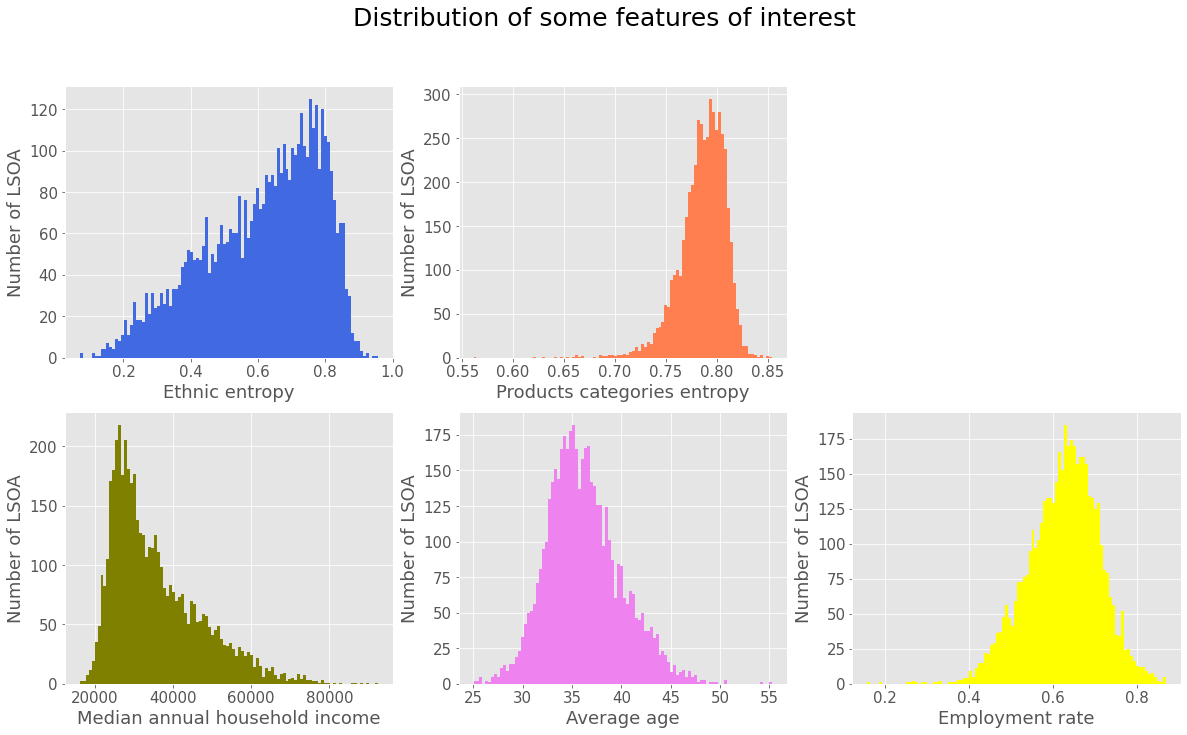

Ethnic entropy distribution: median = 0.644, mean = 0.612, std = 0.173


Product categories entropy distribution: median = 0.789, mean = 0.786, std = 0.023


Median annual household income distribution: median = 32609.000, mean = 35755.819, std = 11461.029


Average age distribution: median = 35.823, mean = 36.222, std = 3.755


Employment rate distribution: median = 0.631, mean = 0.624, std = 0.085


In [13]:
style.use('ggplot')

fig, ax = plt.subplots(2,3,figsize=(20,11))

plt.suptitle("Distribution of some features of interest", fontsize=25)

ax[0,0].hist(full_df['Ethnic_Group;h_ethnicities_norm;2011'], 100, color='royalblue')
ax[0,0].set_xlabel('Ethnic entropy', fontsize=18)
ax[0,0].set_ylabel('Number of LSOA', fontsize=18)
ax[0,0].tick_params(labelsize=15)

ax[0,1].hist(full_df['h_items_norm'], 100, color='coral')
ax[0,1].set_xlabel('Products categories entropy', fontsize=18)
ax[0,1].set_ylabel('Number of LSOA', fontsize=18)
ax[0,1].tick_params(labelsize=15)

ax[0,2].axis('off')

ax[1,0].hist(full_df['Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)'], 100, color='olive')
ax[1,0].set_xlabel('Median annual household income', fontsize=18)
ax[1,0].set_ylabel('Number of LSOA', fontsize=18)
ax[1,0].tick_params(labelsize=15)

ax[1,1].hist(full_df['avg_age'], 100, color='violet')
ax[1,1].set_xlabel('Average age', fontsize=18)
ax[1,1].set_ylabel('Number of LSOA', fontsize=18)
ax[1,1].tick_params(labelsize=15)

ax[1,2].hist(full_df['Economic_Activity;Employment_ratio;2011'], 100, color='yellow')
ax[1,2].set_xlabel('Employment rate', fontsize=18)
ax[1,2].set_ylabel('Number of LSOA', fontsize=18)
ax[1,2].tick_params(labelsize=15)

plt.show()

print('Ethnic entropy distribution: median = {0:1.3f}, mean = {1:1.3f}, std = {2:1.3f}'\
      .format(np.median(full_df['Ethnic_Group;h_ethnicities_norm;2011']),
              np.mean(full_df['Ethnic_Group;h_ethnicities_norm;2011']),
              np.std(full_df['Ethnic_Group;h_ethnicities_norm;2011'])))
print('\n')
print('Product categories entropy distribution: median = {0:1.3f}, mean = {1:1.3f}, std = {2:1.3f}'\
      .format(np.median(full_df['h_items_norm']),
              np.mean(full_df['h_items_norm']),
              np.std(full_df['h_items_norm'])))
print('\n')
print('Median annual household income distribution: median = {0:1.3f}, mean = {1:1.3f}, std = {2:1.3f}'\
      .format(np.median(full_df['Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)']),
              np.mean(full_df['Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)']),
              np.std(full_df['Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)'])))
print('\n')
print('Average age distribution: median = {0:1.3f}, mean = {1:1.3f}, std = {2:1.3f}'\
      .format(np.median(full_df['avg_age']),
              np.mean(full_df['avg_age']),
              np.std(full_df['avg_age'])))
print('\n')
print('Employment rate distribution: median = {0:1.3f}, mean = {1:1.3f}, std = {2:1.3f}'\
      .format(np.median(full_df['Economic_Activity;Employment_ratio;2011']),
              np.mean(full_df['Economic_Activity;Employment_ratio;2011']),
              np.std(full_df['Economic_Activity;Employment_ratio;2011'])))

# changed

We can see multiple interesting things. 
We first observe that the normalized ethnic entropy distribution spans almost accross the whole range of possible values (0 to 1). The distribution is also skewed toward larger entropy values. This means that our dataset present both area with high and low ehtnic diversity, with ethnically diverse area being more represented.
The food products categories entropy distribution however shows a much smaller variance accross LSOA with a high mean value. 
With the rather large difference of variance of those two distributions, we can expect not to see dramatic effects on the product diversity when comparing areas featuring highly different ethnic diversity. This does not necessarly mean that those effects will not be significative.

Looking at other socio-economic feature we suspect that could play a role as confounder of our effect, we see that the median income distribution spans accross a large range of value with a 4 to 5 fold ratio between minimum and maximum values. The distribution is skewed toward lower values telling us that there are more areas with lower annual median income per household. 
The average age distribution looks like a normal distribution, as well as the employment rate distribution.

By looking at some of the main features in our dataset we see multiple interesting things. For example, the food purchase entropy does not seem like it varies a lot from an LSOA to another. As a lot of items are sold in Tesco, it is clear that the diversity in food purchase is high in general. In comparison, the median household income or the average age have a high variance from one LSOA to another, because the population can be completely different between areas. Think about an area in the center of London, compared to one in its suburbs. As housing prices are higher in the center, people that can afford such flats/houses tend to earn more money. Now if we come back to food purchase diversity: it is clear that, even if some people purchase a larger variation of items than other, these differences are small compared to the ones of other metrics. It is easy to find a Londoner earning 10x more money as another Londoner, but the same thing cannot be said for food purchase diversity. Therefore, food purchase diversity inherently has less variance than the other features presented here and it does not mean that differences in this feature cannot be meaningful.
Ethnic entropy has a lot of variance, with some areas very diverse in terms of ethnicities represented, while others are more conservative.

# Added

We can also see how our two main feature of interest (the entropy of the distribution of the different ethnic groups and the entropy of the distribution of the different food products categories) are displayed geographically on a map of London

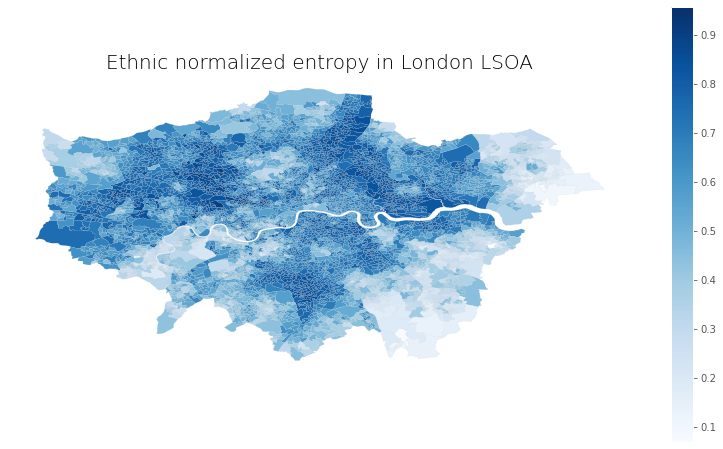

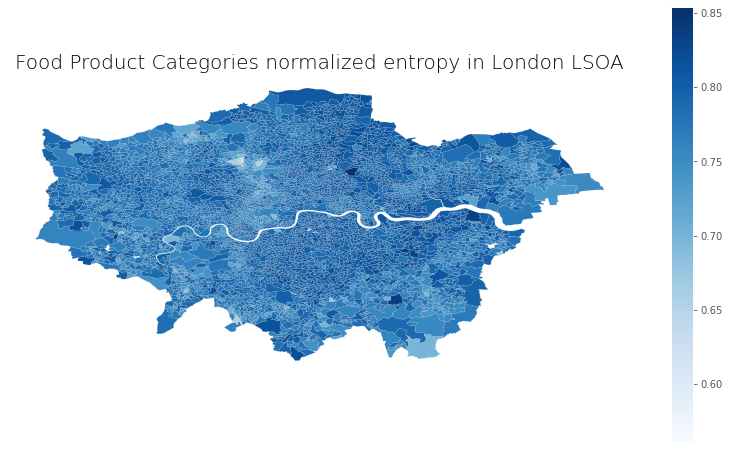

In [14]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'Ethnic_Group;h_ethnicities_norm;2011'
# set the range for the choropleth
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(14, 8))
vmin = np.min(full_df[variable])
vmax = np.max(full_df[variable])


# create map
full_df.plot(column=variable, cmap='Blues', linewidth=0.1, ax=ax, edgecolor='0.8')
ax.axis('off')
# add a title
ax.set_title('Ethnic normalized entropy in London LSOA', fontdict={'fontsize': '20', 'fontweight' : '3'})

# Create colorbar as a legend
smap = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
smap._A = []
# add the colorbar to the figure
cbar = fig.colorbar(smap)

plt.show()


# set a variable that will call whatever column we want to visualise on the map
variable = 'h_items_norm'
# set the range for the choropleth
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(14, 8))
vmin = np.min(full_df[variable])
vmax = np.max(full_df[variable])

# create map
full_df.plot(column=variable, cmap='Blues', linewidth=0.1, ax=ax, edgecolor='0.8')
ax.axis('off')
# add a title
ax.set_title('Food Product Categories normalized entropy in London LSOA', fontdict={'fontsize': '20', 'fontweight' : '3'})

# Create colorbar as a legend
smap = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
smap._A = []
# add the colorbar to the figure
cbar = fig.colorbar(smap)

plt.show()

# Added

As expected after looking at the distributions of those two features, we can see a much greater variance in ethnic entropy. We can distinguish three main cluster of more ethnically diverse areas separated by les diverse ones. One interesting aspect of this representation, is that we can see that while having a majority of more ethnically diverse area, those tends to be have a smaller surface.
The food product categories diversity is more even accross the whole London area.

---
# changed


## 6. Correlation analysis

To begin our analysis, we want to see if there are significative relations between the ditstibutions of the different product categories and of the different ethnic groups represented in our dataset. We compute the Spearman rank correlation between those features at different level of granularity.

- Correlation between the normalized entropy of the product categories distribution and the normalized entropy of ethnic groups distribution
- Correlation between the different proportions of ethnic groups and the normalized entropy of the product category distribution
- Correlation between the different proportions of ethnic groups and different proportions of product categories

To assess the significance of those correlations, we use a Bonferroni corrected significance value of $\frac{\alpha}{n}$ where $\alpha = 0.05$ and $n$ is the number of different correlation computed in each of our test.

# changed 

### 6.1. Correlation between ethnic diversity and product categories diversity

In [15]:
h_ethnicity = full_df['Ethnic_Group;h_ethnicities_norm;2011'].values
h_items = full_df['h_items_norm'].values
h_items_food = full_df['h_items_food_norm'].values
h_items_drink = full_df['h_items_drink_norm'].values

rho_items, p_items = spearmanr(h_ethnicity, h_items)
rho_food, p_food = spearmanr(h_ethnicity, h_items_food)
rho_drink, p_drinks = spearmanr(h_ethnicity, h_items_drink)

d = {'Products': ['all','food', 'drink'],
     'R': [rho_items, rho_food, rho_drink],
     'p-value': [p_items, p_food, p_drinks]}
hh_corr_df = pd.DataFrame(data=d)
hh_corr_df

Products         R        p-value
0      all  0.368818  1.285898e-155
1     food  0.286189   9.082810e-92
2    drink  0.192731   1.157947e-41

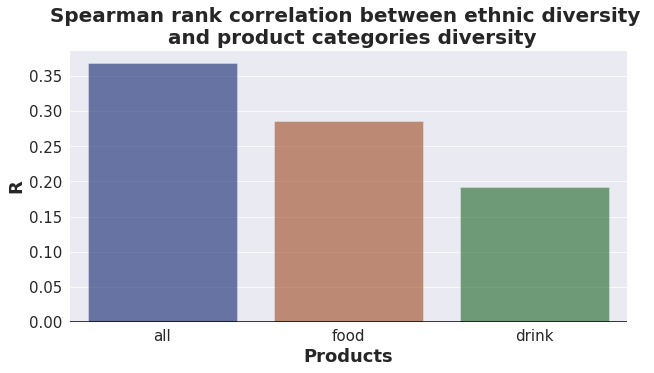

In [16]:
# CHANGED

# keep only the significant data
n_test = 3
alpha_adj = 0.05/n_test # Bonferroni adjusted alpha
hh_plot_df = hh_corr_df[hh_corr_df['p-value'] < alpha_adj]

sns.set_style("dark")

plt.figure(figsize=(10,5))
ax = sns.barplot(x='Products', y='R', data=hh_plot_df, palette='dark', alpha=.6)
ax.grid(axis='y')
ax.set_ylabel('R', fontsize=18, fontweight='bold')
ax.set_xlabel('Products', fontsize=18, fontweight='bold')

#plt.xticks(rotation=90 )
ax.axhline(y=0, color='k', linestyle='-')
ax.set_title('Spearman rank correlation between ethnic diversity \n and product categories diversity',
             fontsize=20, fontweight='bold')
ax.tick_params(labelsize=15)
plt.show()

# changed

Value of the Spearman rank correlation (R) between the normalized entropy of the different ethnic groups distributions and the normalized entropy of all product categories distributions (left), the normalized entropy of the food-only product categories distributions (middle) and the normalized entropy of the drink-only product categories distribution (right). Only significative correlations with $p-value < \frac{0.05}{3}$ are reported. 

As we can see on this figure, there is a positive correlation between the ethnic diversity in an area and the diversity of products in the shopping carts. We can also see that the ethnic diversity is more correlated with food products diversity than with drinks.


# not relevant with what we said earlier on representatitvity
From this first analysis, we could hypothesise that having more ethnic diversity in an area leads to a multiplicity of different diets influenced by cultural factors. Since product categories can have a different prevalence accross various dietary habits, having more of those various diets would tend to even the proportions of the different categories, hence to increase the product diversity.
We could also hypothesise that the cultural aspects of different diets is more dicted by what the people eat than what they drink.

### 6.2. Correlation between the different proportions of ethnic groups and product categories diversity

In [17]:
f_ethnicity_idx_lo = full_df.columns.get_loc('Ethnic_Group;White_(ratio);2011')
f_ethnicity_idx_hi = full_df.columns.get_loc('Ethnic_Group;Other_ethnic_group_(ratio);2011')+1

# list containing the name of the ethnic groups
ethnicity_col = np.array(full_df.columns[f_ethnicity_idx_lo:f_ethnicity_idx_hi]) 
ethnic_col_short = np.array(['White', 'Mixed', 'Asian', 'Black', 'Other ethnic groups'])

n_ethnicity = ethnicity_col.shape[0]

# list containing the name of the item categories (food or drink)
category_col = np.array(['all',
                         'food',
                         'drink'])
n_category = category_col.shape[0]

# repeat elements to have same length and suitable format
ethnicity_col = np.repeat(ethnicity_col, n_category)
ethnic_col_short = np.repeat(ethnic_col_short, n_category)
category_col = np.tile(category_col, n_ethnicity)

# list containing the values of the ethnic group representations
f_ethnicities = []
for col in full_df.iloc[:, f_ethnicity_idx_lo:f_ethnicity_idx_hi].columns:
    f_ethnicities.append(full_df[col].values)

# list containing the values of items entropy for food and drink
h_items = full_df['h_items_norm'].values
h_items_food = full_df['h_items_food_norm'].values
h_items_drink = full_df['h_items_drink_norm'].values
h_item_categories = [h_items, h_items_food, h_items_drink]

# compute the correlation and their p-values
R_col = []
p_col = []
for et in f_ethnicities:
    for cat in h_item_categories:
        R, p = spearmanr(et, cat)
        R_col.append(R)
        p_col.append(p)

d = {'Ethnic group': ethnic_col_short.tolist(),
     'Products': category_col.tolist(),
     'R': R_col,
     'p-value': p_col}

fh_corr_df = pd.DataFrame(data = d)
fh_corr_df

Ethnic group Products         R        p-value
0                 White      all -0.236992   1.109595e-62
1                 White     food -0.148771   2.537757e-25
2                 White    drink -0.155952   1.082312e-27
3                 Mixed      all  0.441581  7.456270e-230
4                 Mixed     food  0.310607  1.375516e-108
5                 Mixed    drink  0.249160   2.676778e-69
6                 Asian      all -0.114748   1.227568e-15
7                 Asian     food -0.053519   1.974140e-04
8                 Asian    drink -0.078691   4.310637e-08
9                 Black      all  0.572196   0.000000e+00
10                Black     food  0.366747  9.108755e-154
11                Black    drink  0.362461  5.570965e-150
12  Other ethnic groups      all  0.064052   8.339283e-06
13  Other ethnic groups     food  0.132814   1.828360e-20
14  Other ethnic groups    drink -0.036551   1.104659e-02

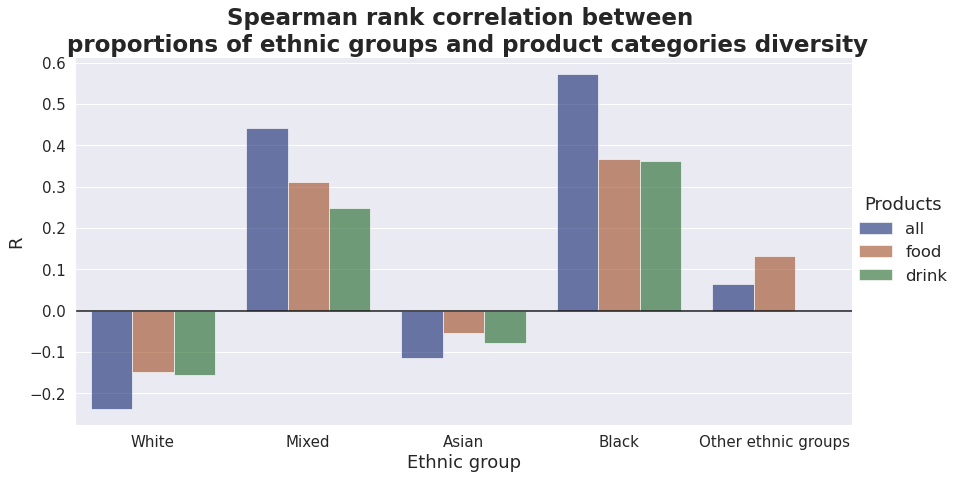

In [18]:
# keep only the significant data 
n_test = 15
alpha_adj = 0.05/n_test # Bonferroni adjusted alpha
fh_plot_df = fh_corr_df[fh_corr_df['p-value'] < alpha_adj]

sns.set_style("dark")
sns.set(font_scale=1.5)

g = sns.catplot(data=fh_plot_df, kind="bar", x="Ethnic group", y="R", hue="Products", palette="dark", 
                alpha=.6, height=6, aspect=2)

for ax in g.axes.flat:
    ax.grid(True, axis='y')
ax.axhline(y=0, color='k')

#plt.xticks(rotation=45 )

ax.tick_params(labelsize=15)

ax.set_title('Spearman rank correlation between \n proportions of ethnic groups and product categories diversity',
             fontsize=23, fontweight='bold')

plt.show()

# Changed

Value of the Spearman rank correlation (R) between the proportions of the different ethnic groups and the normalized entropy of all product categories distributions, food-only product categories distribution and drink-only product categories distributions. Only significative correlations with $p-value < \frac{0.05}{15}$ are reported. 

From this figure, we can see that the proportions of the different ethnic groups correlates diferently with the products diversity. Mixed and Black ethnic groups show positive correlation, the black ethnic group being the one featuring the largest positive correlation with product diversity. White and Asian ethnic groups show negative correlation, white ethnic group being the one with the most negative correlation value. The other ethnic groups have a lower positive correlation value and is the only group to display a non significative correlation value (drinks). 
A positive correlation value implies that 

At this point of our analysis, we are limited by the level of representativity of the Tesco dataset. Indeed, since the data we have can not cover all the food consumption habit of the inhabitants of London, it is impossible to tell if the correlation value between the proportion of a certain group and the diversity of product is due to an overall less diversified diet or simply less diversified purchases at Tesco itself. A negative correlation value could for example be due to the fact that a specific group tends to get some particular products at Tesco and turn to other more specific sources (ethnic shops, farmers markets, bakeries, etc.) for the rest of their groceries.

# changed

### 6.3. Correlation between the different proportions of ethnic groups and different proportions of product categories

In [19]:
# list containing names of the different products proportions
f_items_idx_lo = full_df.columns.get_loc('f_beer') 
f_items_idx_hi = full_df.columns.get_loc('f_wine')+1
item_col = np.array(full_df.columns[f_items_idx_lo:f_items_idx_hi]) # list containing name of the columns
n_item = item_col.shape[0]

# list containing names of the different ethnic groups
f_ethnicity_idx_lo = full_df.columns.get_loc('Ethnic_Group;White_(ratio);2011')
f_ethnicity_idx_hi = full_df.columns.get_loc('Ethnic_Group;Other_ethnic_group_(ratio);2011')+1
ethnicity_col = np.array(full_df.columns[f_ethnicity_idx_lo:f_ethnicity_idx_hi]) # list containing name of the columns
ethnicity_col_short = np.array(['White', 'Mixed', 'Asian', 'Black', 'Other ethnicities'])
n_ethnicity = ethnicity_col.shape[0]

# repeat elements to get good format
item_col = np.tile(item_col, n_ethnicity)
ethnicity_col = np.repeat(ethnicity_col, n_item)
ethnicity_col_short = np.repeat(ethnicity_col_short, n_item)


f_items = []
for col in full_df.iloc[:, f_items_idx_lo:f_items_idx_hi].columns:
    f_items.append(full_df[col].values)

f_ethnicities = []
for col in full_df.iloc[:, f_ethnicity_idx_lo:f_ethnicity_idx_hi].columns:
    f_ethnicities.append(full_df[col].values)
    
R_col = []
p_col = []

for et in f_ethnicities:
    for item in f_items:
        R, p = spearmanr(et, item)
        R_col.append(R)
        p_col.append(p)

d = {'Ethnicity': ethnicity_col.tolist(),
     'Item': item_col.tolist(),
     'R': R_col,
     'p-value': p_col}
      
ff_corr_df = pd.DataFrame(data = d)

# add a "Category column" to label items as food or drink
def is_food_or_drink(Item):
    
    food_list = set(['f_dairy',
                     'f_eggs',
                     'f_fats_oils',
                     'f_fish',
                     'f_fruit_veg',
                     'f_grains',
                     'f_meat_red',
                     'f_poultry',
                     'f_readymade',
                     'f_sauces',
                     'f_sweets'])

    drink_list = set(['f_beer',
                      'f_soft_drinks',
                      'f_spirits',
                      'f_tea_coffee',
                      'f_water',
                      'f_wine'])
    
    if Item in food_list :
        return "food"
    elif Item in drink_list :
        return "drink"

ff_corr_df.insert(1, 'Category', ff_corr_df['Item'].apply(is_food_or_drink), True)
ff_corr_df

Ethnicity Category          Item  \
0                Ethnic_Group;White_(ratio);2011    drink        f_beer   
1                Ethnic_Group;White_(ratio);2011     food       f_dairy   
2                Ethnic_Group;White_(ratio);2011     food        f_eggs   
3                Ethnic_Group;White_(ratio);2011     food   f_fats_oils   
4                Ethnic_Group;White_(ratio);2011     food        f_fish   
..                                           ...      ...           ...   
80  Ethnic_Group;Other_ethnic_group_(ratio);2011    drink     f_spirits   
81  Ethnic_Group;Other_ethnic_group_(ratio);2011     food      f_sweets   
82  Ethnic_Group;Other_ethnic_group_(ratio);2011    drink  f_tea_coffee   
83  Ethnic_Group;Other_ethnic_group_(ratio);2011    drink       f_water   
84  Ethnic_Group;Other_ethnic_group_(ratio);2011    drink        f_wine   

           R        p-value  
0   0.205189   4.187796e-47  
1  -0.273152   1.895280e-83  
2  -0.309786  5.383464e-108  
3  -0.426744  3.490461e-213  
4  -0.013208   3.586075e-01  
..       ...            ...  
80  0.098075   8.323222e-12  
81 -0.239118   8.226865e-64  
82  0.110457   1.354980e-14  
83  0.189520   2.553798e-40  
84 -0.099253   4.666605e-12  

[85 rows x 5 columns]

<ipython-input-20-2a2af2e30caa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['R'][plot_df['p-value'] >= alpha_adj] = np.nan


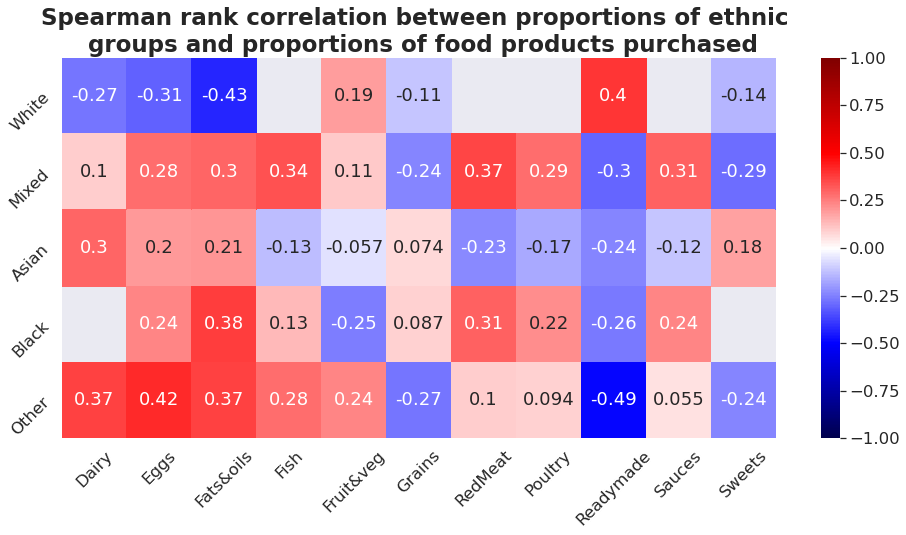

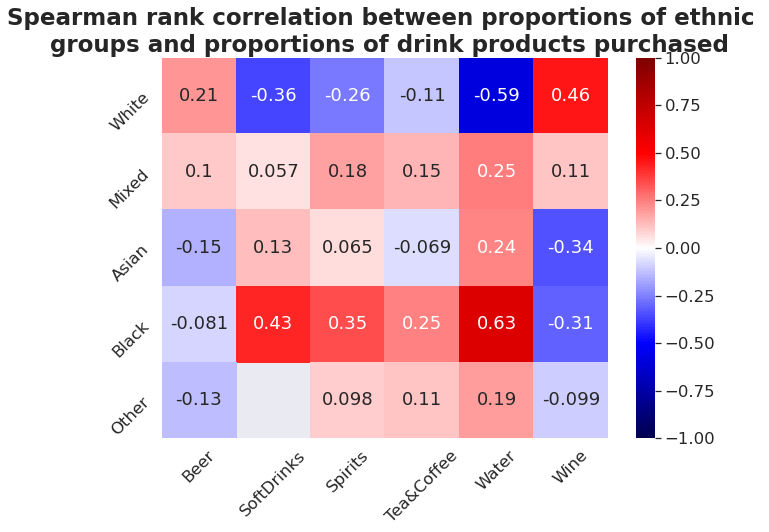

In [20]:
# keep only the significant data
n_test = 85
alpha_adj = 0.05/n_test # Bonferroni adjusted alpha
plot_df = ff_corr_df.copy()
plot_df['R'][plot_df['p-value'] >= alpha_adj] = np.nan
plot_df

ethnicity_list = np.array(full_df.columns[f_ethnicity_idx_lo:f_ethnicity_idx_hi]).tolist()
n_ethnicity = len(ethnicity_list)
n_food = 11
n_drink = 6

R_food_np = np.zeros((n_ethnicity, n_food))
R_drink_np = np.zeros((n_ethnicity, n_drink))

for i in range(n_ethnicity):
    R_food_np[i,:] = plot_df['R'][np.logical_and(plot_df['Ethnicity'] == ethnicity_list[i], plot_df['Category'] == 'food')]
    R_drink_np[i,:] = plot_df['R'][np.logical_and(plot_df['Ethnicity'] == ethnicity_list[i], plot_df['Category'] == 'drink')]


ethnicities_list = ['White',
                    'Mixed',
                    'Asian',
                    'Black',
                    'Other']    
    
food_list = ['Dairy',
             'Eggs',
             'Fats&oils',
             'Fish',
             'Fruit&veg',
             'Grains',
             'RedMeat',
             'Poultry',
             'Readymade',
             'Sauces',
             'Sweets']

drink_list = ['Beer',
              'SoftDrinks',
              'Spirits',
              'Tea&Coffee',
              'Water',
              'Wine']


plt.figure(figsize=(16,7))
ax = sns.heatmap(R_food_np, annot=True, vmin=-1, vmax=1, cmap='seismic')
ax.set_title('Spearman rank correlation between proportions of ethnic \n groups and proportions of food products purchased', 
             fontsize=23, fontweight='bold')

ax.set_xticklabels(food_list)
plt.xticks(rotation=45)
ax.set_yticklabels(ethnicities_list)
plt.yticks(rotation=45)

plt.figure(figsize=(10,7))
ax = sns.heatmap(R_drink_np, annot=True, vmin=-1, vmax=1, cmap='seismic')
ax.set_title('Spearman rank correlation between proportions of ethnic \n groups and proportions of drink products purchased', 
             fontsize=23, fontweight='bold')

ax.set_xticklabels(drink_list)
plt.xticks(rotation=45)
ax.set_yticklabels(ethnicities_list)
plt.yticks(rotation=45)
plt.show()

# changed

Figures above show the correlation between the proportions of the different ethnic groups and the proportions of the different products in a heatmap. Food and drinks related products are shown on different heatmaps for readability purposes.  Positively and negatively correlated proportions are showed respectively in red and blue. Only significative correlations with $p-value < \frac{0.05}{85}$ are reported, non-significative correlations are represented as gray cells with no correlation values. 

With this level of granularity, we can see that the proportions of the different ethnic groups correlate differently to the proportions of specific food and drink products.
Those results can help to explain the correlation found in the previous figure.
Wee indeed see that ethnic groups that showed a more positive correlation with item diversity (Mixed, Black and Other) tends to have a majority of positively correlated proportion of items.
For the two groups that showed negative correlation with item diversity (White and Asian), we can see that they present a majority of negatively correlated features. 


## TO ADD CONCLUSION (2-3 examples of interpretation + reminder of the limitations (Tesco or regime alimentaire ?) --> LINK WITH CAUSALITY ANALYSIS

---

## 7. Causality analysis

## TO ADD
#### On a vu qu'il y a des effets --> est ce que ces effets sont causaux ?
#### --> summary de ce qu'on va faire et des methodes qu'on utilise

### 7.1. Naive initial analysis using Linear Regression

To get an idea of the effect of multiple features on food purchase diversity, we first performed a linear regression analysis. 

From our intuition, we selected features that we initially thought impacted food purchase diversity the most. We standardized them to be able to interpret better the weight of each feature selected on the output feature (`h_items`).

In [21]:
employment_rate = full_df['Economic_Activity;Employment_ratio;2011']
employment_rate_stand = (employment_rate - np.mean(employment_rate))/np.std(employment_rate)

median_household_income = full_df['Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)']
median_household_income_stand = (median_household_income - np.mean(median_household_income))/np.std(median_household_income)

avg_age = full_df['avg_age']
avg_age_stand = (avg_age - np.mean(avg_age))/np.std(avg_age)

h_items = full_df['h_items_norm']
h_items_stand = (h_items - np.mean(h_items))/np.std(h_items)

h_ethnicity = full_df['Ethnic_Group;h_ethnicities_norm;2011']
h_ethnicity_stand = (h_ethnicity - np.mean(h_ethnicity))/np.std(h_ethnicity)

We then build a dataframe containing the data that will be used in this part of the analysis.

In [22]:
lin_reg_df = pd.DataFrame()
lin_reg_df['employment_rate'] = employment_rate_stand
lin_reg_df['median_household_income'] = median_household_income_stand
lin_reg_df['avg_age'] = avg_age_stand
lin_reg_df['h_items'] = h_items_stand
lin_reg_df['h_ethnicity'] = h_ethnicity_stand
lin_reg_df.head()

employment_rate  median_household_income   avg_age  \
LSOA11NM                                                                        
City of London 001A               1.465458                 1.971130  3.214820   
City of London 001B               1.453738                 1.867475  2.976434   
City of London 001C               0.563031                -0.119432  3.232598   
City of London 001E              -0.409714                -1.025721 -0.162352   
Barking and Dagenham 016A        -0.444873                 0.295365 -1.102792   

                            h_items  h_ethnicity  
LSOA11NM                                          
City of London 001A       -1.382446    -1.378456  
City of London 001B       -1.104701    -1.896204  
City of London 001C        0.359911    -0.798115  
City of London 001E       -0.182977     0.927231  
Barking and Dagenham 016A -0.245228     0.639302

First, we will try to keep only the ethnic entropy (`h_ethnicity`) to try to explain the food purchase entropy (`h_items`). We will use the statsmodels module.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df['h_ethnicity'],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsmod = sm.OLS(y_train, X_train)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                h_items   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     425.2
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           4.42e-89
Time:                        15:30:22   Log-Likelihood:                -4616.2
No. Observations:                3383   AIC:                             9236.
Df Residuals:                    3381   BIC:                             9249.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0069      0.016      0.421      

---

We observe that 11.2% of the variance of `h_items` is explained by `h_ethnicity`, and that the effect is significant.

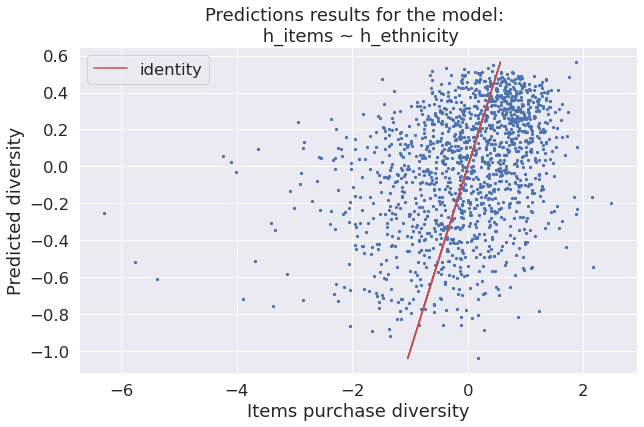

In [24]:
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(y_test, olsres.predict(X_test), s=5, c='b');
plt.plot(olsres.predict(X_test), olsres.predict(X_test), c='r', label='identity')
plt.legend()
plt.xlabel('Items purchase diversity')
plt.ylabel('Predicted diversity')
plt.title('Predictions results for the model: \n h_items ~ h_ethnicity')
plt.show()


We will now try to explain the variance in the food purchase entropy (`h_items`) with the following features of each LSOA:
- The ethnic entropy: `h_ethnicity`
- The employment rate: `employment_rate`
- The average age: `avg_age`
- The median income per household: `median_household_income`

The results will give us an idea about the contribution and significance of each term when predicting the value of `h_items`

In [25]:
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df[['h_ethnicity', 'employment_rate', 
                                                               'avg_age', 'median_household_income']],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsmod = sm.OLS(y_train, X_train)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                h_items   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     181.2
Date:                Fri, 18 Dec 2020   Prob (F-statistic):          7.46e-141
Time:                        15:30:22   Log-Likelihood:                -4487.8
No. Observations:                3383   AIC:                             8986.
Df Residuals:                    3378   BIC:                             9016.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

---

When adding the employment rate, the median household income and the average age of the LSOA's population in the predicting factors, $R^2$ only rises from 11.2 to 17.7 %. This seems to suggest that the ethnic entropy has a non-negligible effect on the food purchase category entropy.

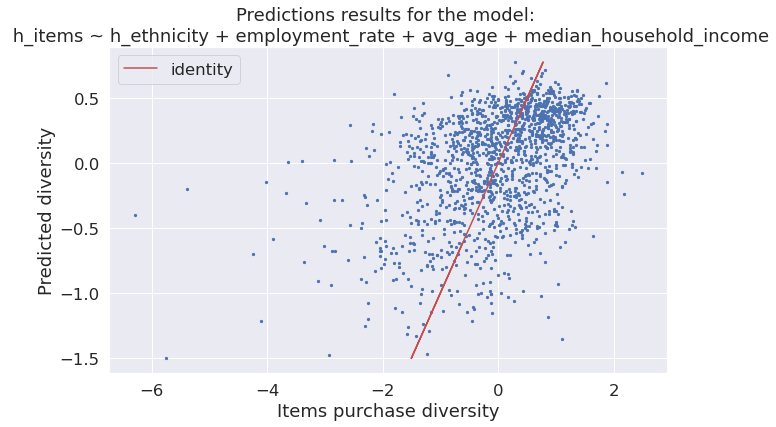

In [26]:
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(y_test, olsres.predict(X_test), s=5, c='b');
plt.plot(olsres.predict(X_test), olsres.predict(X_test), c='r', label='identity')
plt.legend()
plt.xlabel('Items purchase diversity')
plt.ylabel('Predicted diversity')
plt.title('Predictions results for the model: \n h_items ~ h_ethnicity + employment_rate + avg_age + median_household_income')
plt.show()

From these results, it looks like all four predictive factors have a significant effect on the food purchase entropy. They suggest the following conclusions:
- LSOA with more ethnic diversity tend to have a larger food purchase diversity
- LSOA with a higher employment rate tend to have a larger food purchase diversity
- LSOA with a higher average age tend to have a lower food purchase diversity
- LSOA with a larger median income per household tend to have a lower food purchase diversity

As the features are standardized, the magnitude of their coefficients can be directly compared. This suggests that `median_household_income` impacts `h_items` the most, followed by `h_ethnicity`, `employment_rate` and finally `avg_age`. Even though it seems that ethnic diversity has an effect on food purchase diversity in an LSOA, we still need to be careful with the conclusions we might take here. Indeed, we could be in a situation where for example the `median_household_income` feature is a confounder and therefore it influences both `h_items` and `h_ethnicity`. We could therefore see an effect of `h_ethnicity` on `h_items`, even though it is actually `median_household_income` which impacts both indirectly. In this case, the effect of `h_ethnicity` on `h_items` could entirely be explained by `median_household_income`. To ensure that we are not in such a situation, we will use the notion of matching. We will perform Generalized Propensity Score (GPS) matching. This will allow us to take into account and remove the effect of potential confounders in the analysis of the ethnic entropy's effect on food purchase entropy.

Let us now select the most significant features of the full dataset from a statistical viewpoint, to reduce the dimensionality of the statistical analysis.

### 7.2. Propensity Score matching

#### Towards propensity score matching with a continuous treatment feature

In the ADA course, we learned about propensity score matching. It is very useful to minimize the impact of confounders on the analysis of the effect of a feature (called the treatment) on another feature (called the output). Indeed, until now, we have focused on simple and naive correlations, giving no information about causality whatsoever, as well as linear regressions which only slightly bring a notion of causality in the analysis. To dig deeper in the analysis of the effect of ethnic diversity on food purchase diversity and to know if causality is involved here, we will perform a propensity score matching. The goal is to match samples together using a propensity score, which represents the probability that a sample has been treated (treatment value = 1, in opposition to 0 when not treated) based on the values of some of its other features (the ones used to compute the score). 

However, in the ADA course, propensity score matching was performed with a binary treatment feature. This makes it a lot easier. Indeed, by default it cuts the dataset in two groups whose respective samples can then be matched together. In this present case, the treatment we would like to study is the ethnic entropy, a continuous feature. As the dataset cannot really be cut in the same manner when using a continuous treatment feature, it is not as straightforward as the binary case. Of course, there is always the solution of binarizing the continuous feature. It can simply be done by setting a threshold in the treatment feature: the samples with a higher value form the first group and the samples with an equal or lower value form the second group. This solution has a critical drawback though: it makes it very difficult to interpret the results of the treatment effect. Indeed, if the matching works well, and in the end a significant effect is found, it means the following thing: if a sample belongs to the first group, the output feature is significantly larger/lower (depending on the effect of the treatment) than it would be if this sample was in the second group (and therefore if its treatment was lower). Let us say that the threshold is set such that the two resulting groups have the same size. As groups are formed via a threshold on a continuous feature, it means that being in the top 50 % of samples in terms of the treatment feature value impacts a sample's output feature. But what about a sample at 49 % compared to one at 51 %? Is there really such a hard boundary? In most cases, no. Indeed, the threshold is often arbitrary in the case of a continuous feature. 

To account for the fact that the treatment feature is continuous, we decided to use an implementation of **Generalized Propensity Score (GPS)** matching. Matching is performed on two values: the propensity score of the sample, computed using a regression on the features selected to build the score (potential confounders whose effect needs to be minimized), and its continuous treatment value. Similar samples on these two values are matched together. The output of the algorithm is called a Causal Dose Response (CDR) curve. It computes the effect of the treatment on the output by calculating the predicted output value in function of the treatment value. If the treatment has an effect, then the curve is not flat, i.e. the predicted output changes depending on the treatment. The GPS algorithm outputs a confidence interval and we can use it to assess the significance of the resulting CDR curve.

First, we need to filter the full dataset once again to keep only the numerical features for our general propensity analysis

# DEVELOPP (Max)

In [27]:
filtered_df = full_df.loc[:, 'h_items_norm':'people_per_sq_km']
filtered_df = pd.concat([ filtered_df, full_df.loc[:, 'Households;All_households;2011':'h_household_compo_norm']], axis=1)
filtered_df = pd.concat([ filtered_df, full_df.loc[:, 'Ethnic_Group;h_ethnicities_norm;2011':]], axis=1)
filtered_df.drop(['Country_of_Birth;ratio_Not_United_Kingdom;2011'], axis=1, inplace=True)
filtered_df.drop(['Household_Language;ratio_of_households_where_no_people_aged_16_or_over_have_English_as_a_main_language;2011'], axis=1, inplace=True)
###
filtered_df.drop(['Economic_Activity;Unemployment_ratio;2011'], axis=1, inplace=True)
###

print(filtered_df.shape)
filtered_df

for col in filtered_df.columns:
    print(col)

(4833, 82)
h_items_norm
representativeness_norm
transaction_days
num_transactions
man_day
population
male
female
age_0_17
age_18_64
age_65+
avg_age
h_age_norm
area_sq_km
people_per_sq_km
Households;All_households;2011
Household_Composition;ratio_Couple_household_with_dependent_children;2011
Household_Composition;ratio_Couple_household_without_dependent_children;2011
Household_Composition;ratio_Lone_parent_household;2011
Household_Composition;ratio_One_person_household;2011
Household_Composition;ratio_Other_multi_person_household;2011
h_household_compo_norm
Ethnic_Group;h_ethnicities_norm;2011
Country_of_Birth;ratio_United_Kingdom;2011
Household_Language;ratio_of_households_with_at_least_one_person_aged_16_or_over_with_English_as_a_main_language;2011
Religion;Christian_(ratio);2011
Religion;Buddhist_(ratio);2011
Religion;Hindu_(ratio);2011
Religion;Jewish_(ratio);2011
Religion;Muslim_(ratio);2011
Religion;Sikh_(ratio);2011
Religion;Other_religion_(ratio);2011
Religion;No_religion_(ratio

We then standardize the dataset. Indeed, each feature is continuous and therefore we can directly perform it on the whole dataframe.

In [28]:
std_df = (filtered_df - filtered_df.mean()) / filtered_df.std()
std_df.sample(5)

Adults_in_Employment;ratio_of_households_with_no_adults_in_employment:_With_dependent_children;2011  \
LSOA11NM                                                                                                                         
Islington 009C                                                      0.571070                                                     
Richmond upon Thames 013F                                          -0.708358                                                     
Newham 022A                                                         0.315184                                                     
Enfield 004D                                                       -0.964243                                                     
Redbridge 026B                                                      0.315184                                                     

                           Car_or_van_availability;1_car_or_van_in_household_(ratio);2011  \
LSOA11NM                                                                                    
Islington 009C                                                     -0.956897                
Richmond upon Thames 013F                                           0.157617                
Newham 022A                                                        -1.795914                
Enfield 004D                                                        0.307889                
Redbridge 026B                                                      0.570864                

                           Car_or_van_availability;2_cars_or_vans_in_household_(ratio);2011  \
LSOA11NM                                                                                      
Islington 009C                                                     -1.026332                  
Richmond upon Thames 013F                                           1.675087                  
Newham 022A                                                        -0.873996                  
Enfield 004D                                                        1.807111                  
Redbridge 026B                                                     -0.000605                  

                           Car_or_van_availability;3_cars_or_vans_in_household_(ratio);2011  \
LSOA11NM                                                                                      
Islington 009C                                                     -0.794576                  
Richmond upon Thames 013F                                           2.096581                  
Newham 022A                                                        -0.761345                  
Enfield 004D                                                        2.362434                  
Redbridge 026B                                                     -0.096711                  

                           Car_or_van_availability;4_or_more_cars_or_vans_in_household_(ratio);2011  \
LSOA11NM                                                                                              
Islington 009C                                                     -0.749174                          
Richmond upon Thames 013F                                           2.166350                          
Newham 022A                                                        -0.830161                          
Enfield 004D                                                        1.194509                          
Redbridge 026B                                                     -0.344240                          

                           Car_or_van_availability;No_cars_or_vans_in_household_(ratio);2011  \
LSOA11NM                                                                                       
Islington 009C                                                      1.132253                   
Richmond upon Thames 013F                                          -1.443866                   
Newham 022A               

The goal is now to select the features that we want to use in the propensity score. The output feature (i.e. the one we want to predict in the end) is `h_items_norm`, and we will therefore compute the Spearman correlation between `h_items_norm` and all the other features.

In [29]:
n_features = std_df.shape[1]

correl_df = pd.DataFrame(0, index=range(n_features-1), columns=['feature', 'correlation', 'p_value'])
feature_list = std_df.columns.tolist()
feature_list.remove('h_items_norm') 
correl_df['feature'] = feature_list

for i, col in enumerate(feature_list):
    correl, pval = spearmanr(std_df['h_items_norm'], std_df[col])
    correl_df.loc[i, 'correlation'] = correl
    correl_df.loc[i, 'p_value'] = pval

correl_df.head()

feature  correlation  \
0  Adults_in_Employment;ratio_of_households_with_...     0.402207   
1  Car_or_van_availability;1_car_or_van_in_househ...    -0.127561   
2  Car_or_van_availability;2_cars_or_vans_in_hous...    -0.328573   
3  Car_or_van_availability;3_cars_or_vans_in_hous...    -0.307831   
4  Car_or_van_availability;4_or_more_cars_or_vans...    -0.305167   

         p_value  
0  2.178904e-187  
1   5.479353e-19  
2  4.965303e-122  
3  1.359370e-106  
4  1.066943e-104

Let us now discard the features for which the correlation with the output feature is not significant (i.e. their associated p-value > 0.05/n, with n the number of tests)

In [30]:
# keep only the significant data
# Bonferroni adjusted alpha
n_test = len(correl_df)
alpha_adj = 0.05/n_test

filtered_correl_df = correl_df[ correl_df['p_value'] < alpha_adj ]

filtered_correl_df.shape

(73, 3)

Let's now sort the features from the most to the least correlated to `h_items_norm`, using the absolute value of the correlation coefficent.

In [31]:
filtered_correl_df.insert(2,"abs_correlation", np.abs(filtered_correl_df['correlation']))
sorted_correl_df = filtered_correl_df.sort_values('abs_correlation', ascending=False)
sorted_correl_df.head(10)

feature  correlation  \
29  Household_Composition;ratio_Lone_parent_househ...     0.453982   
16  Economic_Activity;Economically_active:_Unemplo...     0.425294   
54                 Tenure;Owned_outright_(ratio);2011    -0.415181   
57                  Tenure;Social_rented_(ratio);2011     0.412346   
0   Adults_in_Employment;ratio_of_households_with_...     0.402207   
28  Household_Composition;ratio_Couple_household_w...    -0.378579   
70                             h_household_compo_norm     0.369545   
18               Ethnic_Group;h_ethnicities_norm;2011     0.368818   
32  Household_Income,_2011/12;Mean_Annual_Househol...    -0.352765   
33  Household_Income,_2011/12;Median_Annual_Househ...    -0.351866   

    abs_correlation        p_value  
29         0.453982  1.938682e-244  
16         0.425294  1.344982e-211  
54         0.415181  9.295447e-201  
57         0.412346  8.727722e-198  
0          0.402207  2.178904e-187  
28         0.378579  1.593143e-164  
70         0.369545  2.856378e-156  
18         0.368818  1.285898e-155  
32         0.352765  1.258317e-141  
33         0.351866  7.241041e-141

Let's keep the top N features for the General Propensity Score computation. In this case, to simplify the readability and level of interpretation of the following results, we will use N = 10.

In [32]:
main_features = sorted_correl_df.head(10)['feature'].tolist()
main_features.append('h_items_norm')
features_df = std_df[main_features]
features_df.columns

Index(['Household_Composition;ratio_Lone_parent_household;2011',
       'Economic_Activity;Economically_active:_Unemployed;2011',
       'Tenure;Owned_outright_(ratio);2011',
       'Tenure;Social_rented_(ratio);2011',
       'Adults_in_Employment;ratio_of_households_with_no_adults_in_employment:_With_dependent_children;2011',
       'Household_Composition;ratio_Couple_household_without_dependent_children;2011',
       'h_household_compo_norm', 'Ethnic_Group;h_ethnicities_norm;2011',
       'Household_Income,_2011/12;Mean_Annual_Household_Income_estimate_(£)',
       'Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)',
       'h_items_norm'],
      dtype='object')

It turns out that the treatment feature (the ethnic entropy) is among the features kept. If it was not the case, it would not be a problem. However, it is encouraging for the rest of the analysis.

In [33]:
features_df = features_df.rename(columns={"Household_Composition;ratio_Lone_parent_household;2011": "lone_parents",
                            "Economic_Activity;Economically_active:_Unemployed;2011": "unemployed", 
                            "Economic_Activity;Unemployment_ratio;2011": "unemployment",
                            "Tenure;Owned_outright_(ratio);2011": "owned_tenure",
                            "Tenure;Social_rented_(ratio);2011": "social_rented_tenure",
                            "Adults_in_Employment;ratio_of_households_with_no_adults_in_employment:_With_dependent_children;2011":
                            "households_no_adults_employed",
                            "Household_Composition;ratio_Couple_household_without_dependent_children;2011": 
                            "couple_household_no_children",
                            "Ethnic_Group;h_ethnicities_norm;2011": "h_ethnic",
                            "Household_Income,_2011/12;Mean_Annual_Household_Income_estimate_(£)": "household_mean_income"})

We will now compute the Generalized Propensity Score (GPS).

In [34]:
gps = GPS(gps_family=None,
          treatment_grid_num=100,
          lower_grid_constraint=0.2,
          upper_grid_constraint=0.8,
          spline_order=3,
          n_splines=15, # maximum number of turning points (knots) to be used during the smoothing process
          lambda_=0.5,
          max_iter=500,
          random_seed=None,
          verbose=False)

features = features_df.columns.to_list()
features.remove('h_items_norm')
#features.remove('h_ethnic')

treat_feat = 'h_ethnic'
features.remove(treat_feat)

# Fits the causal dose-response model.
gps.fit(T = features_df[treat_feat], 
        X = features_df[features], 
        y = features_df['h_items_norm'])

gps_results = gps.calculate_CDRC(0.95)

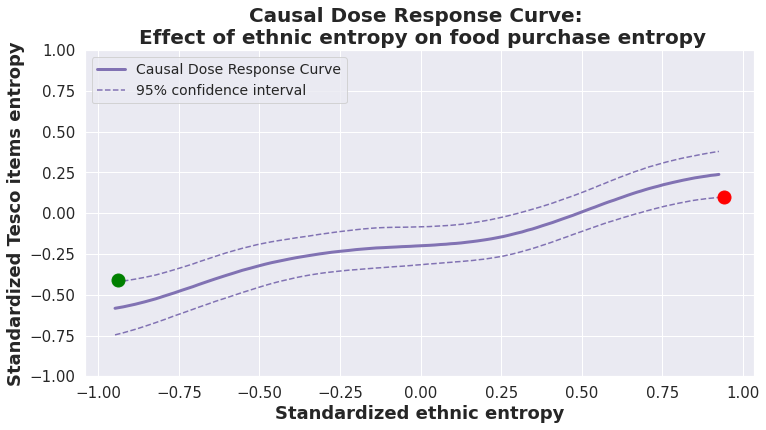

In [35]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(gps_results['Treatment'], gps_results['Causal_Dose_Response'], label='Causal Dose Response Curve',
         c='m', linewidth=3)
plt.plot(gps_results['Treatment'], gps_results['Lower_CI'], 'm--', label='95% confidence interval')
plt.plot(gps_results['Treatment'], gps_results['Upper_CI'], 'm--')
plt.ylim(-1,1)
ax.legend()
plt.title('Causal Dose Response Curve: \n Effect of ethnic entropy on food purchase entropy',
          fontsize=20, fontweight='bold')
plt.xlabel('Standardized ethnic entropy', fontsize=18, fontweight='bold')
plt.ylabel('Standardized Tesco items entropy', fontsize=18, fontweight='bold')

# plot points to highlight how the metric we will use works
plt.plot([-0.94], [-0.41], marker='o', markersize=13, color="green")
plt.plot([0.94], [0.1], marker='o', markersize=13, color="red")

plt.tick_params(labelsize=15)

plt.legend(loc=2, prop={'size': 14})

plt.show()

To measure the significance of the effect of ethnic entropy on food purchase entropy, we thought about a metric. It is quite straightforward and surely it already exists, but we have not been able to find anyone else using or defining it.

Let us look at the plot above to define this metric on a concrete example. In this case, the CDR curve has an approximately constant positive slope. We observe that no horizontal line can be drawn inside the confidence interval (CI). As a horizontal line corresponds to the treatment having no effect on the output, in the case of the curve above we interpret that the effect of the treatment on the output is significant.

Now, how can we capture this information using a simple and robust metric? If we look at the difference between the maximum value of the lower CI (the red dot on the plot) and the minimum value of the upper CI (the green dot), we observe that in this case it is positive. Indeed, the red dot has a larger y-value (standarized `h_items`) than the green dot. By definition, this difference being positive verifies that no horizontal line can be drawn inside the CI. Since we took the 95% CI, not being able to draw an horizontal line fully contained within the CI ensures that there is less than 5% chance of wrongly rejecting the null hypothesis (type I error) of having no causality between the two features.  
Here is the value of the metric in this case:

In [36]:
treatment_effect_metric = (gps_results['Lower_CI'].max() - gps_results['Upper_CI'].min())
print("The causality significance metric has a value of {0:.3f}.".format(treatment_effect_metric))

The causality significance metric has a value of 0.518.


Let us compare this example to another one, to better grasp how this metric works. Here is the CDR curve, with the number of male in the area as a treatment feature.

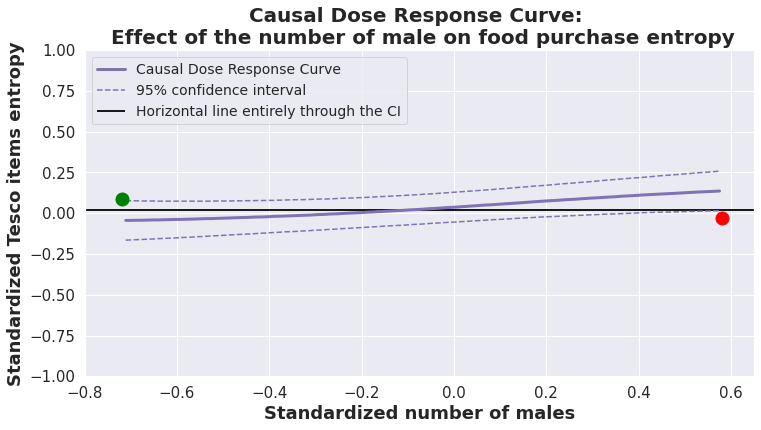

In [37]:
gps = GPS(gps_family=None, treatment_grid_num=100, lower_grid_constraint=0.2, upper_grid_constraint=0.8, spline_order=3,
          n_splines=15, lambda_=0.5, max_iter=500, random_seed=None, verbose=False)

features = features_df.columns.to_list()
features.remove('h_items_norm')

treat_feat = 'male'

gps.fit(T = std_df[treat_feat], X = features_df[features], y = features_df['h_items_norm'])
gps_results = gps.calculate_CDRC(0.95)

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(gps_results['Treatment'], gps_results['Causal_Dose_Response'], label='Causal Dose Response Curve', c='m', linewidth=3)
plt.plot(gps_results['Treatment'], gps_results['Lower_CI'], 'm--', label='95% confidence interval')
plt.plot(gps_results['Treatment'], gps_results['Upper_CI'], 'm--')
plt.plot([-0.72], [0.09], marker='o', markersize=13, color="green")
plt.plot([0.58], [-0.03], marker='o', markersize=13, color="red")
plt.hlines(0.02, -1, 1, color='k', linewidth=2, label='Horizontal line entirely through the CI')

plt.title('Causal Dose Response Curve: \n Effect of the number of male on food purchase entropy', fontsize=20, fontweight='bold')
plt.xlabel('Standardized number of males', fontsize=18, fontweight='bold')
plt.ylabel('Standardized Tesco items entropy', fontsize=18, fontweight='bold')

ax.legend()
plt.ylim(-1,1)
plt.xlim(-0.8,0.65)
plt.tick_params(labelsize=15)
plt.legend(loc=2, prop={'size': 14})

plt.show()

We can observe that in this case, the green dot has a larger y-value compared to the red dot, in turn meaning that the metric is negative. It is clear that a horizontal line can be drawn inside the CI, as shown by the black line; therefore we rate the effect of this treatment as non significant.

In [38]:
treatment_effect_metric = (gps_results['Lower_CI'].max() - gps_results['Upper_CI'].min())
print("The causality significance metric has a value of {0:.3f}.".format(treatment_effect_metric))

The causality significance metric has a value of -0.059.


The more positive this metric is, the more significant is the effect of the treatment. We do not need to normalize it, as we are already working with a standardized dataframe. In the two examples presented, the max of the lower CI and the min of the upper CI are on the bounds of the interval. Even when this is not the case, the metric still works just fine. Indeed, if we imagine a parabolic CDR curve, the metric will still be negative if a horizontal line can be drawn in the CI, and positive if not. 

This metric is really interesting thanks to the visual intuition it represents and to its simplicity. However, it has a slight drawback: it cannot always capture the magnitude of the treatment effect on the output. Indeed, if the CDR curve is not well estimated by a linear regression (i.e. if it does not look like a line), the value of the _causality significance metric_ could minimize the effect of the treatment. It will always be proportional to the difference between the highest estimated output value in function of the treatment, and its lowest estimated value (because the CI englobes the CDR curve and follows its variations), which is already interesting enough to give an idea of treatment effect magnitude.

#### Modularity

We have now seen in details with the ethnic and food purchase entropies, how we can analyze those features to go from a correlation, telling us how strong the association between the two variables is, to a causality link between them. 
Let's create some functions to perform those analyses in a more condensed way, allowing us to test the causality link between many features appearing to be correlated or not.

To do so, we will use two functions.
- `compute_corr_df()`: Returns a standardized dataframe of the n most correlated features to an outcome feature, as well as a dataframe with the same features but not standardized
- `compute_GPS()`: Compute the Generalized Propensity Score between a treatment and an outcome feature, considering all the other features present in the dataframe as confounding factors. Returns our causality metric as well as the points of the causal dose response curve

In [39]:
##### Function to determine the most correlated features #####
def compute_corr_df(df, treatment_name, outcome_name, n=30, alpha=0.05):
    '''
    Standardize the df
    Compute the correlation between each features of the df and the outcome feature
    Select the significative correlations (for alpha)
    Return a df of only the n most correlated features & the outcome feat
    (& the treatment if not in the most correlated features) 
    Return another df, that is similar but not standardized
    '''
    
    # standardize the df
    std_df = (df - df.mean()) / df.std()
    
    correl_df = pd.DataFrame(0, index=range(df.shape[1]-1), columns=['feature', 'correlation', 'p_value'])
    features = list(df.columns.values)
    features.remove(outcome_name)  
    correl_df['feature'] = features
    
    # compute the correlation on the standardized df
    for i, col in enumerate(features):
        correl, pval = spearmanr(std_df[outcome_name], std_df[col])
        correl_df.loc[i, 'correlation'] = correl
        correl_df.loc[i, 'p_value'] = pval
        
    alpha_adj = alpha/len(correl_df)
    filtered_correl_df = correl_df[correl_df['p_value'] < alpha_adj]
    filtered_correl_df.insert(2,"abs_correlation", np.abs(filtered_correl_df['correlation']))
    sorted_correl_df = filtered_correl_df.sort_values('abs_correlation', ascending=False)
    
    main_features = sorted_correl_df.head(n)['feature'].tolist()
    main_features.append(outcome_name)
    
    ## Check if the treatment is one of the most correlated features, otherwise add it
    if not treatment_name in main_features:
        main_features.append(treatment_name)
    
    corr_features_df = df[main_features]
    std_corr_features_df = std_df[main_features]
    
    return corr_features_df, std_corr_features_df



##### Function to compute the Generalized propensity Score #####

def compute_GPS(df, std_df, treatment_name, outcome_name, plot_std=False, plot_normal=False, CI=0.95, 
                ymin_std=-1, ymax_std=1):
    '''
    Compute the generalized propensity score to determine the Causal Dose Response Curve
    between the treatment and the outcome, considering the other features of the df as confounders
    '''
    gps = GPS(treatment_grid_num=100, lower_grid_constraint=0.2, upper_grid_constraint=0.8, n_splines=15)
    
    features = std_df.columns.to_list()
    features.remove(treatment_name)
    features.remove(outcome_name)

    # Fits the causal dose-response model.
    gps.fit(T = std_df[treatment_name], 
            X = std_df[features], 
            y = std_df[outcome_name])
    
    gps_results = gps.calculate_CDRC(CI)
    
    if plot_std:
        fig, ax = plt.subplots(figsize=(12,6))
        plt.plot(gps_results['Treatment'], gps_results['Causal_Dose_Response'], 
                 label='Causal Dose Response Curve', linewidth=3)
        plt.plot(gps_results['Treatment'], gps_results['Lower_CI'], 'k--', label='95% confidence interval')
        plt.plot(gps_results['Treatment'], gps_results['Upper_CI'], 'k--')
        plt.ylim(ymin_std,ymax_std)
        plt.xlim(-1,1)
        ax.legend()
        plt.title('Causal Dose Response Curve')
        plt.xlabel('Standardized Treatment: ' + treatment_name)
        plt.ylabel('Standardized Outcome: ' + outcome_name)
        plt.show()
        
    if plot_normal:
        
        # destandardize the values
        treat_destd = gps_results['Treatment']*np.std(df[treatment_name]) + np.mean(df[treatment_name])
        
        std_out = np.std(df[outcome_name])
        mean_out = np.mean(df[outcome_name])
        cdr_destd = gps_results['Causal_Dose_Response']*std_out + mean_out
        cdr_destd_low95 = gps_results['Lower_CI']*std_out + mean_out
        cdr_destd_up95 = gps_results['Upper_CI']*std_out + mean_out
        
        #plot
        fig, ax = plt.subplots(figsize=(12,6))
        plt.plot(treat_destd, cdr_destd, label='Causal Dose Response Curve',linewidth=3)
        plt.plot(treat_destd, cdr_destd_low95, 'k--', label='95% confidence interval')
        plt.plot(treat_destd, cdr_destd_up95, 'k--')
        ax.legend()
        plt.title('Causal Dose Response Curve')
        plt.xlabel('Treatment: ' + treatment_name)
        plt.ylabel('Outcome: ' + outcome_name)
        plt.show()
    
    treatment_effect_metric = (gps_results['Lower_CI'].max() - gps_results['Upper_CI'].min())
    
    return gps_results, treatment_effect_metric


### 7.3. Assessing our approach
We have seen that by considering as confounders to the treatment (ethnicity diversity) the features present in the 10 most correlated features to the outcome (food purchase diversity), it results that the correlation observed between those two diversity measures appear to be also causal. 
However, the choice of considering only the 10 most correlated features as potential confounders is arbitrary. Therefore, let's check that this arbitrary choice has no influence on the conclusion drown by looking at the causality metric we obtain considering a more important number of the most correlated to the outcome features.

In [40]:
nb_corr_feat = range(1, 51)
caus_metric = []
treat_feat = 'Ethnic_Group;h_ethnicities_norm;2011'

for nb in nb_corr_feat:
    corr_features_df, std_corr_features_df =  compute_corr_df(filtered_df, treat_feat, 'h_items_norm', n=nb)
    _, treat_eff_met = compute_GPS(corr_features_df, std_corr_features_df, treat_feat, 'h_items_norm')
    caus_metric.append(treat_eff_met)

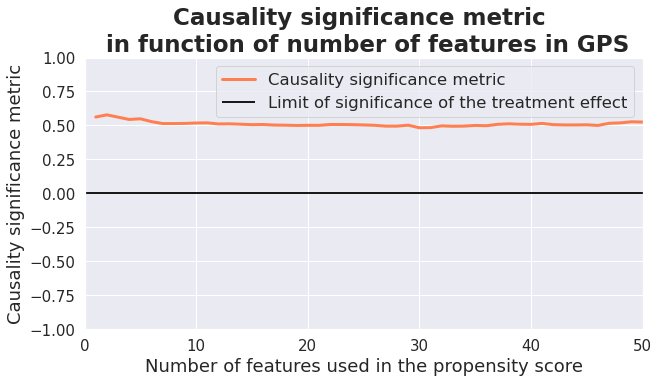

In [41]:
plt.figure(figsize=(10,5))

plt.plot(nb_corr_feat, caus_metric, linewidth=3, color='coral', label='Causality significance metric');
plt.hlines(0, -5, 65, colors='k', linewidth=2, label='Limit of significance of the treatment effect')

plt.title('Causality significance metric \n in function of number of features in GPS', fontsize=23, fontweight='bold')
plt.xlabel('Number of features used in the propensity score', fontsize=18)
plt.ylabel('Causality significance metric', fontsize=18)
plt.tick_params(labelsize=15)

plt.ylim(-1,1);
plt.xlim(0,50)

plt.legend()
plt.show()

Our causality metric doesn't change when considering more correlated features as potential confounders. This tends to assess that considering only the 10 most correlated features is enough to determine the causality between the treatment and the outcome removing the effect of potential confounders. 
However, to ensure that this is not specific to this example and that we are considering enough potential confounders for each analysis, for the following analyses, we will take into account the 30 most correlated features to the outcome as potential confounders of the treatment.

Now let's check that not all the features correlated to the food purchase diversity appear to have a causality link with this latter. If it was the case, then this would mean that something went wrong in our analysis as we aim to identify what are the real causal links that can be observed from the correlated features and not just having another metric that is similar to the correlation. 

In [42]:
## First determine all the features correlated to the diversity in food purchase
## and their correlation value
outcome_name = 'h_items_norm'

# standardize the df
std_df = (filtered_df - filtered_df.mean()) / filtered_df.std()

correl_df = pd.DataFrame(0, index=range(filtered_df.shape[1]-1), 
                         columns=['feature', 'correlation', 'p_value'])

features = list(filtered_df.columns.values)
features.remove(outcome_name)  
correl_df['feature'] = features

# compute the correlation on the standardized df
for i, col in enumerate(features):
    correl, pval = spearmanr(std_df[outcome_name], std_df[col])
    correl_df.loc[i, 'correlation'] = correl
    correl_df.loc[i, 'p_value'] = pval
    
alpha_adj = 0.05/len(correl_df)

filtered_correl_df = correl_df[correl_df['p_value'] < alpha_adj]
filtered_correl_df.insert(2,"abs_correlation", np.abs(filtered_correl_df['correlation']))
sorted_correl_df = filtered_correl_df.sort_values('abs_correlation', ascending=False)

corr_features = sorted_correl_df['feature'].tolist()

In [43]:
sorted_correl_df

feature  correlation  \
17  Household_Composition;ratio_Lone_parent_househ...     0.453982   
52  Economic_Activity;Economically_active:_Unemplo...     0.425294   
34                 Tenure;Owned_outright_(ratio);2011    -0.415181   
36                  Tenure;Social_rented_(ratio);2011     0.412346   
48  Adults_in_Employment;ratio_of_households_with_...     0.402207   
..                                                ...          ...   
45                                    h_dwelling_norm    -0.082974   
31                  Religion;No_religion_(ratio);2011     0.080159   
58  Qualifications;ratio_Highest_level_of_qualific...     0.075731   
23  Household_Language;ratio_of_households_with_at...    -0.072796   
32          Religion;Religion_not_stated_(ratio);2011     0.058962   

    abs_correlation        p_value  
17         0.453982  1.938682e-244  
52         0.425294  1.344982e-211  
34         0.415181  9.295447e-201  
36         0.412346  8.727722e-198  
48         0.402207  2.178904e-187  
..              ...            ...  
45         0.082974   7.612127e-09  
31         0.080159   2.403181e-08  
58         0.075731   1.356561e-07  
23         0.072796   4.059580e-07  
32         0.058962   4.103605e-05  

[73 rows x 4 columns]

In [44]:
# then compute the causality metric considering 30 potential confounders 
caus_metric = []

for treat_feat in corr_features:
    corr_features_df, std_corr_features_df =  compute_corr_df(filtered_df, treat_feat, 'h_items_norm')
    _, treat_eff_met = compute_GPS(corr_features_df, std_corr_features_df, treat_feat, 'h_items_norm')
    caus_metric.append(treat_eff_met)

In [45]:
corr_caus_df = sorted_correl_df[['feature', 'correlation']]
corr_caus_df.insert(2, 'caus_metric', caus_metric)
#is_causal = [True if met < 0 else False for met in caus_metric]
#corr_caus_df['is_causal'] = is_causal

In [46]:
corr_rank = range(1,len(sorted_correl_df)+1)
corr_caus_df['corr_rank'] = corr_rank

sort_caus_df = corr_caus_df.sort_values('caus_metric', ascending=False)
caus_rank = range(1,len(sort_caus_df)+1)
sort_caus_df['caus_rank'] = caus_rank

sort_df = sort_caus_df.sort_values('corr_rank', ascending=True)
sort_df['change_in_rank'] = sort_df['corr_rank'] - sort_df['caus_rank']

In [47]:
# We change the Pandas parameters to be able to display the whole data

pd.set_option("display.max_rows", None, "display.max_columns", None)
display(sort_df)

feature  correlation  \
17  Household_Composition;ratio_Lone_parent_househ...     0.453982   
52  Economic_Activity;Economically_active:_Unemplo...     0.425294   
34                 Tenure;Owned_outright_(ratio);2011    -0.415181   
36                  Tenure;Social_rented_(ratio);2011     0.412346   
48  Adults_in_Employment;ratio_of_households_with_...     0.402207   
16  Household_Composition;ratio_Couple_household_w...    -0.378579   
20                             h_household_compo_norm     0.369545   
21               Ethnic_Group;h_ethnicities_norm;2011     0.368818   
79  Household_Income,_2011/12;Mean_Annual_Househol...    -0.352765   
80  Household_Income,_2011/12;Median_Annual_Househ...    -0.351866   
75  Car_or_van_availability;2_cars_or_vans_in_hous...    -0.328573   
2                                    num_transactions     0.325566   
73  Car_or_van_availability;No_cars_or_vans_in_hou...     0.318836   
9                                             age_65+    -0.312683   
1                                    transaction_days     0.308519   
71         Health;Bad_or_Very_Bad_health_(ratio);2011     0.308294   
76  Car_or_van_availability;3_cars_or_vans_in_hous...    -0.307831   
77  Car_or_van_availability;4_or_more_cars_or_vans...    -0.305167   
78                                   h_car_avail_norm    -0.304450   
10                                            avg_age    -0.303901   
3                                             man_day     0.303739   
55                                h_eco_activity_norm     0.273248   
72                                h_health_state_norm     0.271326   
56        Qualifications;ratio_No_qualifications;2011     0.264386   
69       Health;Very_good_or_Good_health_(ratio);2011    -0.259279   
11                                         h_age_norm    -0.251449   
53  Economic_Activity;Economically_active:_Full-ti...     0.246597   
15  Household_Composition;ratio_Couple_household_w...    -0.245390   
0                             representativeness_norm     0.240443   
64                                      h_qualif_norm     0.239443   
65  Health;Day-to-day_activities_limited_a_lot_(ra...     0.222081   
27                       Religion;Jewish_(ratio);2011    -0.215242   
54            Economic_Activity;Employment_ratio;2011    -0.207625   
70                    Health;Fair_health_(ratio);2011     0.197639   
41  Dwelling_type;Whole_house_or_bungalow:_Detache...    -0.191529   
43  Dwelling_type;Whole_house_or_bungalow:_Terrace...     0.190034   
61  Qualifications;ratio_Highest_level_of_qualific...    -0.186929   
63  Qualifications;ratio_Schoolchildren_and_full-t...     0.183874   
42  Dwelling_type;Whole_house_or_bungalow:_Semi-de...    -0.183813   
13                                   people_per_sq_km     0.182374   
68                                h_health_activ_norm     0.180005   
51  Economic_Activity;Economically_active:_Self-em...    -0.178996   
47                            House_Prices;Sales;2011    -0.177717   
67  Health;Day-to-day_activities_not_limited_(rati...    -0.177545   
35  Tenure;Owned_with_a_mortgage_or_loan_(ratio);2011    -0.171367   
8                                           age_18_64     0.169453   
28                       Religion;Muslim_(ratio);2011     0.168239   
26                        Religion;Hindu_(ratio);2011    -0.165567   
12                                         area_sq_km    -0.165195   
57  Qualifications;ratio_Highest_level_of_qualific...     0.155647   
39  Dwelling_type;Household_spaces_with_at_least_o...     0.154402   
40  Dwelling_type;Household_spaces_with_no_usual_r...    -0.154359   
7                                            age_0_17     0.146550   
18  Household_Composition;ratio_One_person_househo...     0.144497   
44  Dwelling_type;Flat,_maisonette_or_apartment_(r...     0.141760   
19  Household_Composition;ratio_Other_multi_person...     0.138448   
29                         Religion;Sikh_(ratio);2011   

In [48]:
# We change back the Pandas parameters to reasonable values
pd.set_option("display.max_rows", 10, "display.max_columns", 20)

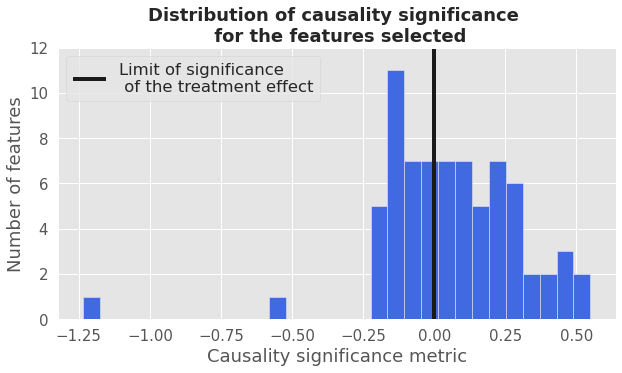

In [49]:
style.use('ggplot')

plt.figure(figsize=(10,5))
plt.hist(caus_metric, color='royalblue', bins=30)
plt.vlines(0,0,20, color='k', label="Limit of significance \n of the treatment effect", linewidth=4)
plt.title("Distribution of causality significance \n for the features selected", fontsize=18, fontweight='bold')
plt.xlabel('Causality significance metric', fontsize=18)
plt.ylabel('Number of features', fontsize=18)
plt.tick_params(labelsize=15)

plt.ylim(0,12)

#plt.legend()
plt.legend(loc=2)
plt.show()

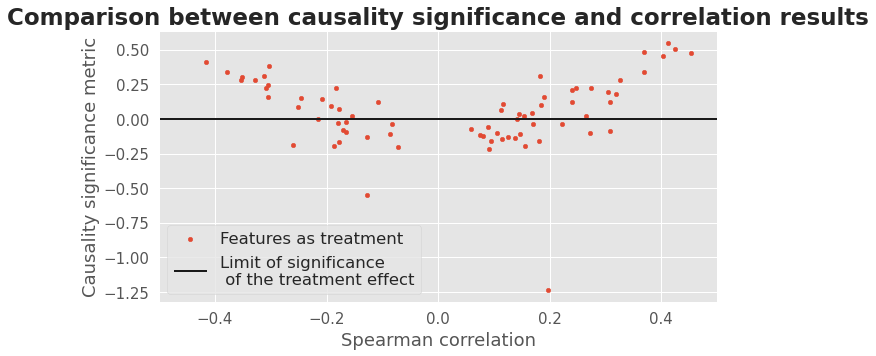

In [50]:
plt.figure(figsize=(10,5))

plt.scatter(corr_caus_df.correlation, corr_caus_df.caus_metric, s=20, label='Features as treatment')
plt.hlines(0, -0.7, 0.7, colors='k', linewidth=2, label='Limit of significance \n of the treatment effect');
#plt.hlines(-0.1, -0.5, 0.5, colors='m', Linestyle='--'); # safety factor ?
plt.xlabel('Spearman correlation', fontsize=18)
plt.ylabel('Causality significance metric', fontsize=18)
plt.title("Comparison between causality significance and correlation results", fontsize=23, fontweight='bold')

plt.xlim(-0.5, 0.5)
plt.tick_params(labelsize=15)

plt.legend()
plt.show()

With those results, we can observe that the ethnicity diversity appears to be the 3rd most causal feature of the food purchase diversity, just behind the feature of the number of person unemployed and the feature of the ratio of social rented tenure in the area.
We can also see that many features that are correlated to the food purchase diversity are in fact not showing any causality link with this feature when considering confounding factors.
In addition, we can observe on the scatter that even though there is a trend showing that the more correlated (in absolute value), the more causal the relationship between the two variables is, this relation is not perfect. This further assess our analysis and findings that there is indeed a causal link between the ethnicity diversity and the food purchase diversity of an area. 


## 7.3. Is our ethnicity reflected in our food purchase ? 

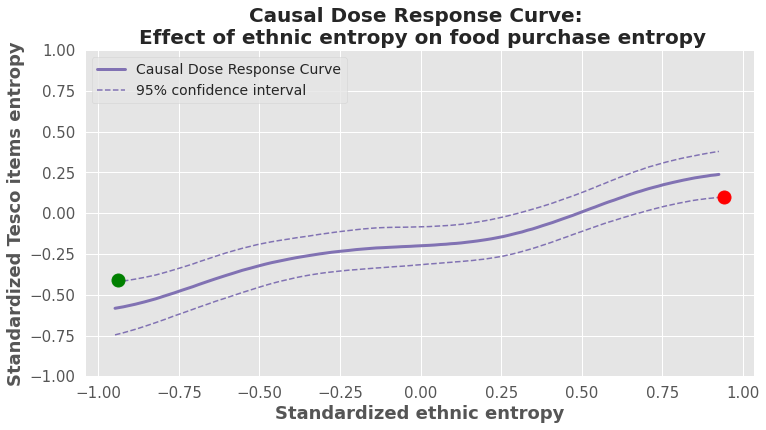

In [51]:
treat_feat = 'Ethnic_Group;h_ethnicities_norm;2011'
corr_features_df, std_corr_features_df =  compute_corr_df(filtered_df, treat_feat, 'h_items_norm', n=10)
gps_results, treat_eff_met = compute_GPS(corr_features_df, std_corr_features_df, treat_feat, 'h_items_norm')

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(gps_results['Treatment'], gps_results['Causal_Dose_Response'], label='Causal Dose Response Curve',
         c='m', linewidth=3)
plt.plot(gps_results['Treatment'], gps_results['Lower_CI'], 'm--', label='95% confidence interval')
plt.plot(gps_results['Treatment'], gps_results['Upper_CI'], 'm--')
plt.ylim(-1,1)
ax.legend()
plt.title('Causal Dose Response Curve: \n Effect of ethnic entropy on food purchase entropy',
          fontsize=20, fontweight='bold')
plt.xlabel('Standardized ethnic entropy', fontsize=18, fontweight='bold')
plt.ylabel('Standardized Tesco items entropy', fontsize=18, fontweight='bold')

# plot points to highlight how the metric we will use works
plt.plot([-0.94], [-0.41], marker='o', markersize=13, color="green")
plt.plot([0.94], [0.1], marker='o', markersize=13, color="red")

plt.tick_params(labelsize=15)

plt.legend(loc=2, prop={'size': 14})

plt.show()

Now that we have clearly identified that the more diverse the population is (in terms of ethnicity), the more diverse the food purchase will be, let's come back to our main question of interest. 

Can we identify food items that are specific to a certain ethnicity ? 

We have seen at the the beginning the different ethnicities were correlated in specific manners to the different food items. However, as for the study done with the food purchase and ethnicity diversity we would like to determine whether those correlations lead to causal links between the different features.

To determine this, we process in a similar manner than previously, computing a generalized propensity score between a treatment and an outcome to remove the effect of confounding factors allowing to identify a causality link between the features.

In [52]:
ethnic_features = ['Ethnic_Group;White_(ratio);2011',
                   'Ethnic_Group;Mixed/multiple_ethnic_groups_(ratio);2011',
                   'Ethnic_Group;Asian/Asian_British_(ratio);2011',
                   'Ethnic_Group;Black/African/Caribbean/Black_British_(ratio);2011',
                   'Ethnic_Group;Other_ethnic_group_(ratio);2011']

ethnic_feat_short = ['White', 'Mixed', 'Asian', 'Black', 'Other']

food_features = ['f_dairy', 'f_eggs', 'f_fats_oils', 'f_fish', 'f_fruit_veg', 
                 'f_grains', 'f_meat_red', 'f_poultry', 'f_readymade', 'f_sauces', 'f_sweets']

drink_features = ['f_beer', 'f_soft_drinks', 'f_spirits','f_tea_coffee', 'f_water', 'f_wine']

In [53]:
filtered_df.index = full_df.index
filtered_df = pd.concat([filtered_df, full_df.loc[:,food_features]], axis=1)
filtered_df = pd.concat([filtered_df, full_df.loc[:,drink_features]], axis=1)
filtered_df = pd.concat([filtered_df, full_df.loc[:,ethnic_features]], axis=1)

In [54]:
res_food_df = pd.DataFrame(columns=['out', 'treat', 'metric'])
caus_curve_food_df = pd.DataFrame(columns=['Treatment', 'Causal_Dose_Response', 
                                           'Lower_CI', 'Upper_CI', 'outcome', 'treatment', 'is_causal'])

for outcome in food_features:
    print(outcome)
    for i, treat in enumerate(ethnic_features):
        corr_features_df, std_corr_features_df =  compute_corr_df(filtered_df, treat, outcome)
        gps_res, treat_eff_metric = compute_GPS(corr_features_df, std_corr_features_df, treat, outcome)
        res_food_df = res_food_df.append({'out': outcome, 'treat': ethnic_feat_short[i], 
                                     'metric': treat_eff_metric}, ignore_index=True)  
        gps_res['outcome'] = np.repeat(outcome, 100)
        gps_res['treatment'] = np.repeat(ethnic_feat_short[i], 100)
        is_causal = (treat_eff_metric > 0)
        gps_res['is_causal'] = np.repeat(is_causal, 100)
        caus_curve_food_df = caus_curve_food_df.append(gps_res, ignore_index=True)

f_dairy
f_eggs
f_fats_oils
f_fish
f_fruit_veg
f_grains
f_meat_red
f_poultry
f_readymade
f_sauces
f_sweets


In [55]:
caus_curve_food_df

Treatment  Causal_Dose_Response  Lower_CI  Upper_CI   outcome treatment  \
0        -0.934                -0.084    -0.312     0.144   f_dairy     White   
1        -0.899                -0.084    -0.312     0.144   f_dairy     White   
2        -0.880                -0.085    -0.312     0.143   f_dairy     White   
3        -0.859                -0.088    -0.314     0.139   f_dairy     White   
4        -0.826                -0.095    -0.320     0.130   f_dairy     White   
...         ...                   ...       ...       ...       ...       ...   
5495      0.468                -0.061    -0.179     0.057  f_sweets     Other   
5496      0.468                -0.061    -0.179     0.057  f_sweets     Other   
5497      0.503                -0.056    -0.177     0.065  f_sweets     Other   
5498      0.539                -0.051    -0.175     0.073  f_sweets     Other   
5499      0.539                -0.051    -0.175     0.073  f_sweets     Other   

     is_causal  
0        False  
1        False  
2        False  
3        False  
4        False  
...        ...  
5495      True  
5496      True  
5497      True  
5498      True  
5499      True  

[5500 rows x 7 columns]

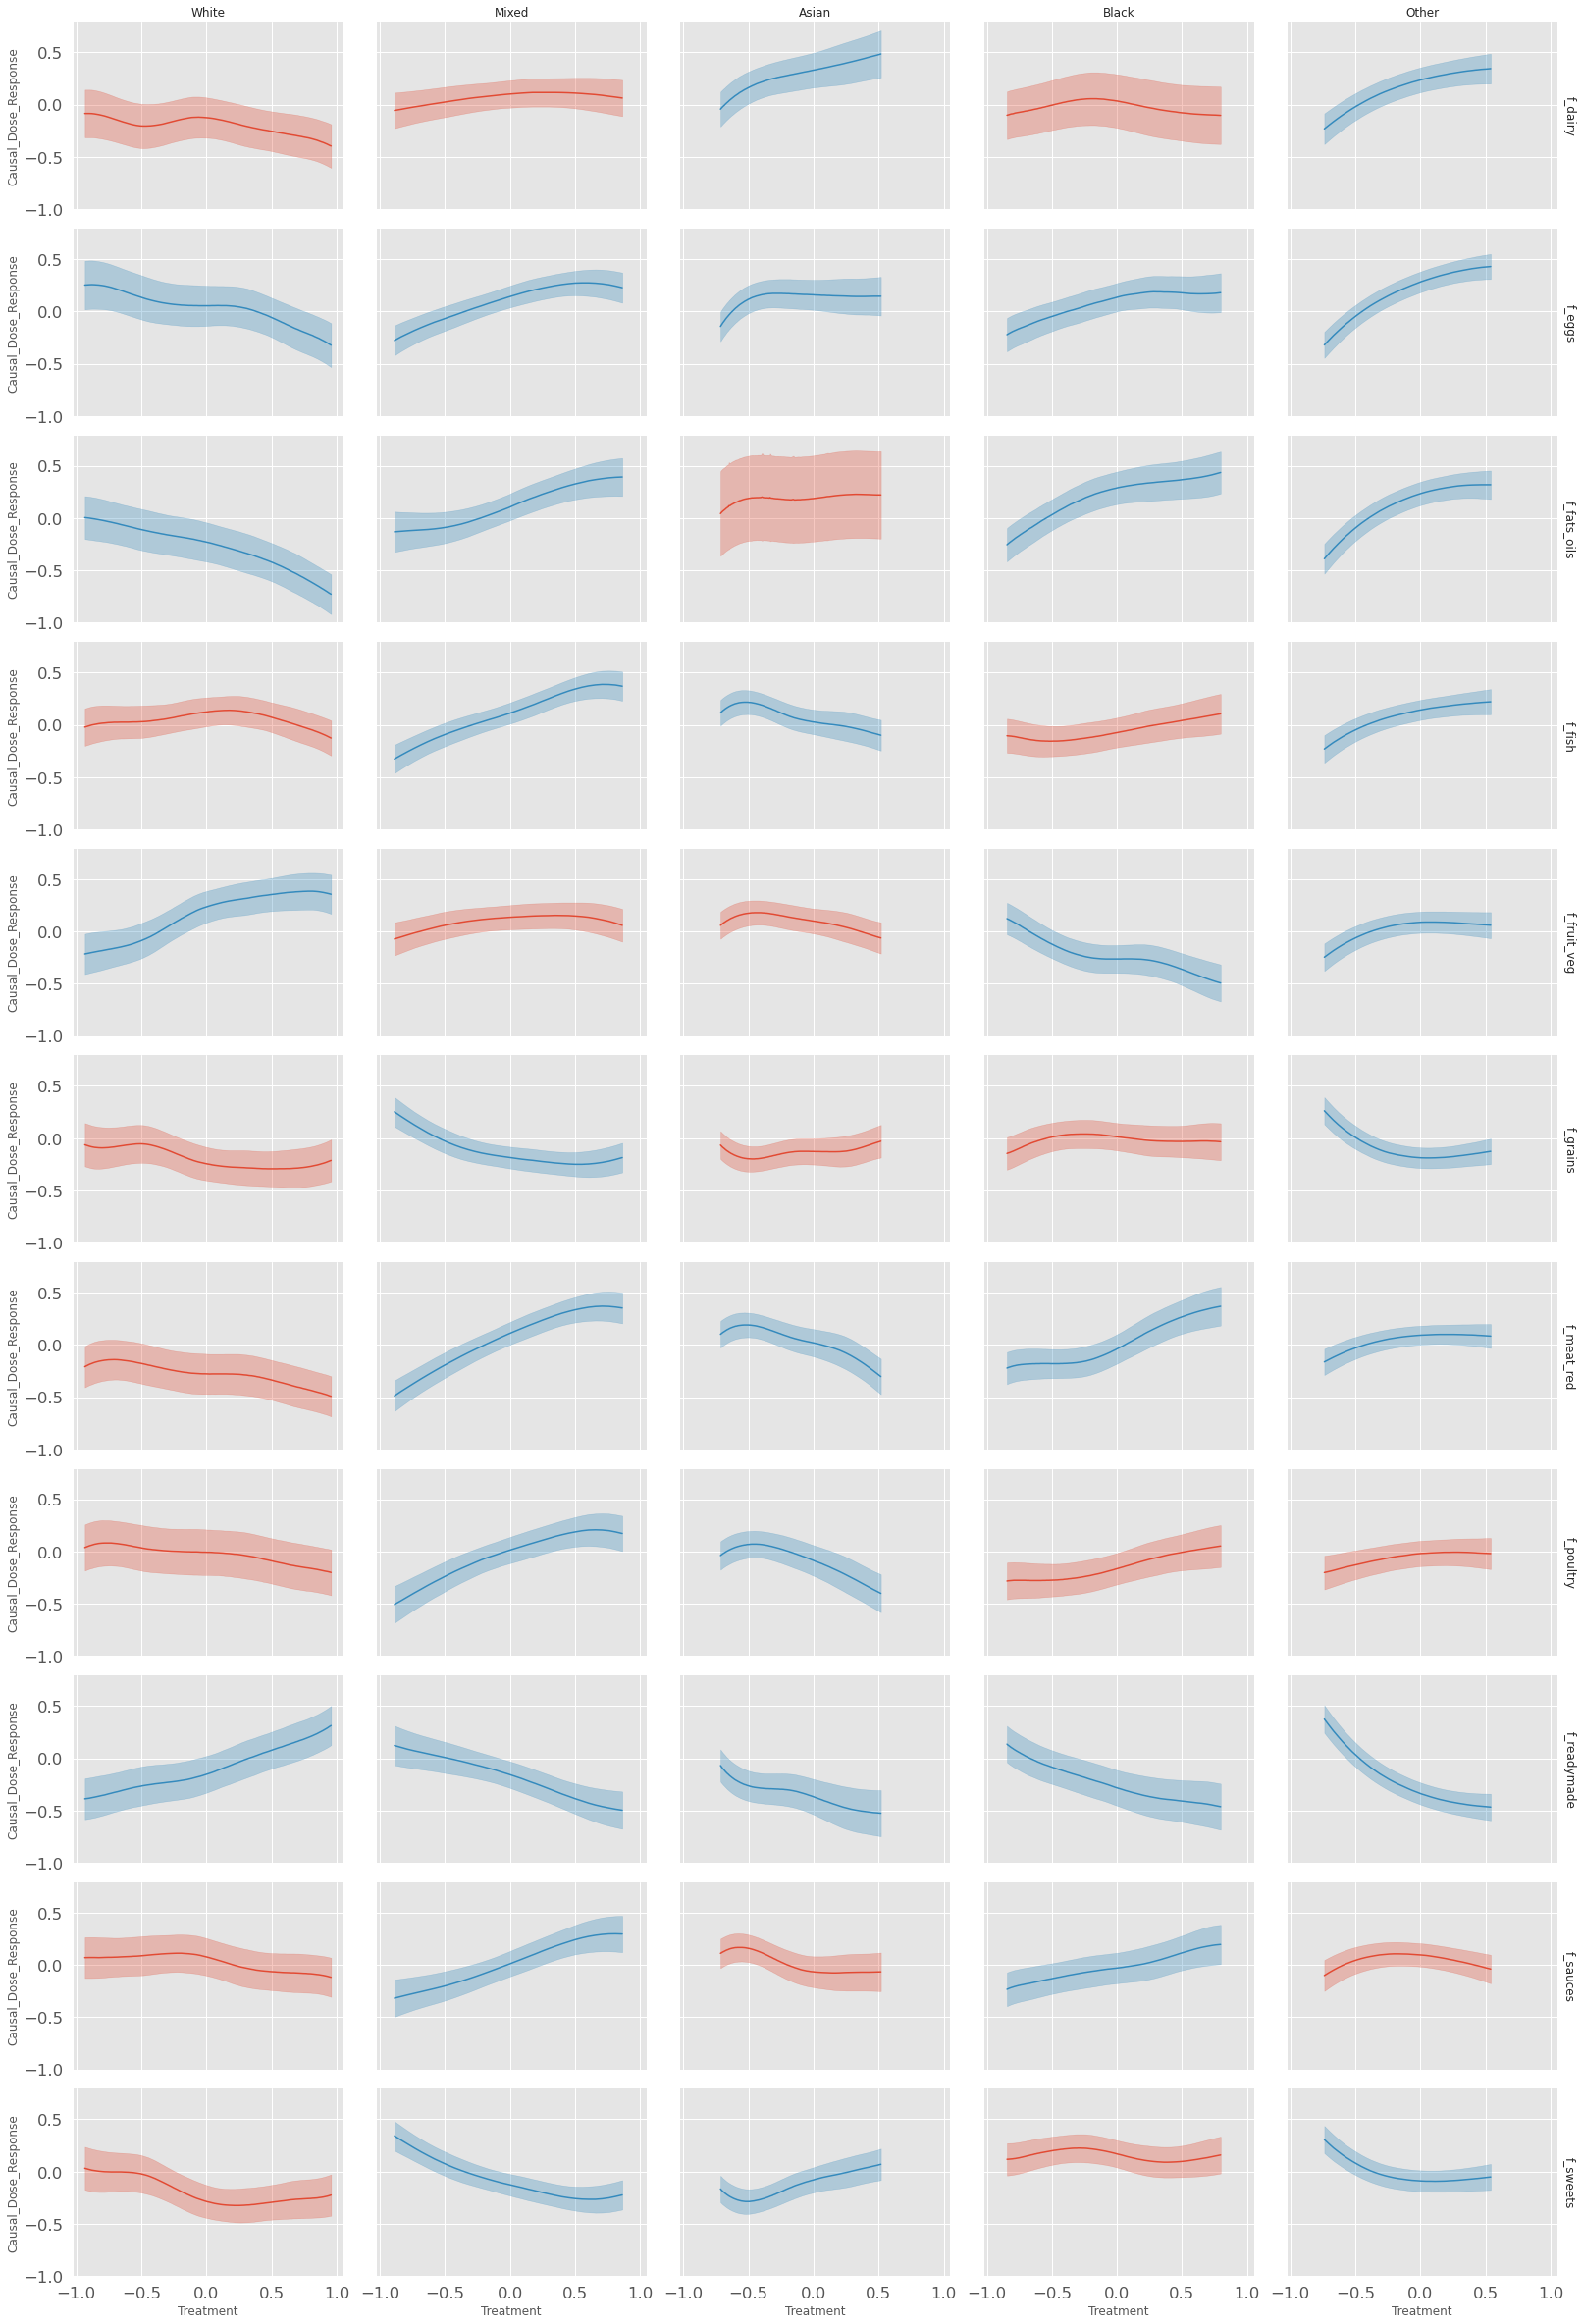

In [56]:
# with sns.plotting_context('paper', font_scale = 1.3):
p = sns.FacetGrid(caus_curve_food_df,
                  row='outcome',
                  col='treatment',
                  hue='is_causal',
                  aspect=1.5,
                  margin_titles=True)
p.map(plt.fill_between, 'Treatment', 'Lower_CI', 'Upper_CI', alpha=.3)
p.map(plt.plot, 'Treatment', 'Causal_Dose_Response')
[plt.setp(ax.texts, text="") for ax in p.axes.flat] # remove the original texts
                                                    # important to add this before setting titles
p.set_titles(row_template = '{row_name}', col_template = '{col_name}')

In [57]:
res_drink_df = pd.DataFrame(columns=['out', 'treat', 'metric'])
caus_curve_drink_df = pd.DataFrame(columns=['Treatment', 'Causal_Dose_Response', 
                                            'Lower_CI', 'Upper_CI', 'outcome', 'treatment'])

for outcome in drink_features:
    print(outcome)
    for i, treat in enumerate(ethnic_features):
        corr_features_df, std_corr_features_df =  compute_corr_df(filtered_df, treat, outcome)
        gps_res, treat_eff_metric = compute_GPS(corr_features_df, std_corr_features_df, treat, outcome)
        res_drink_df = res_drink_df.append({'out': outcome, 'treat': ethnic_feat_short[i], 
                                            'metric': treat_eff_metric}, ignore_index=True)  
        gps_res['outcome'] = np.repeat(outcome, 100)
        gps_res['treatment'] = np.repeat(ethnic_feat_short[i], 100)
        is_causal = (treat_eff_metric > 0)
        gps_res['is_causal'] = np.repeat(is_causal, 100)
        caus_curve_drink_df = caus_curve_drink_df.append(gps_res, ignore_index=True)
         

f_beer
f_soft_drinks
f_spirits
f_tea_coffee
f_water
f_wine


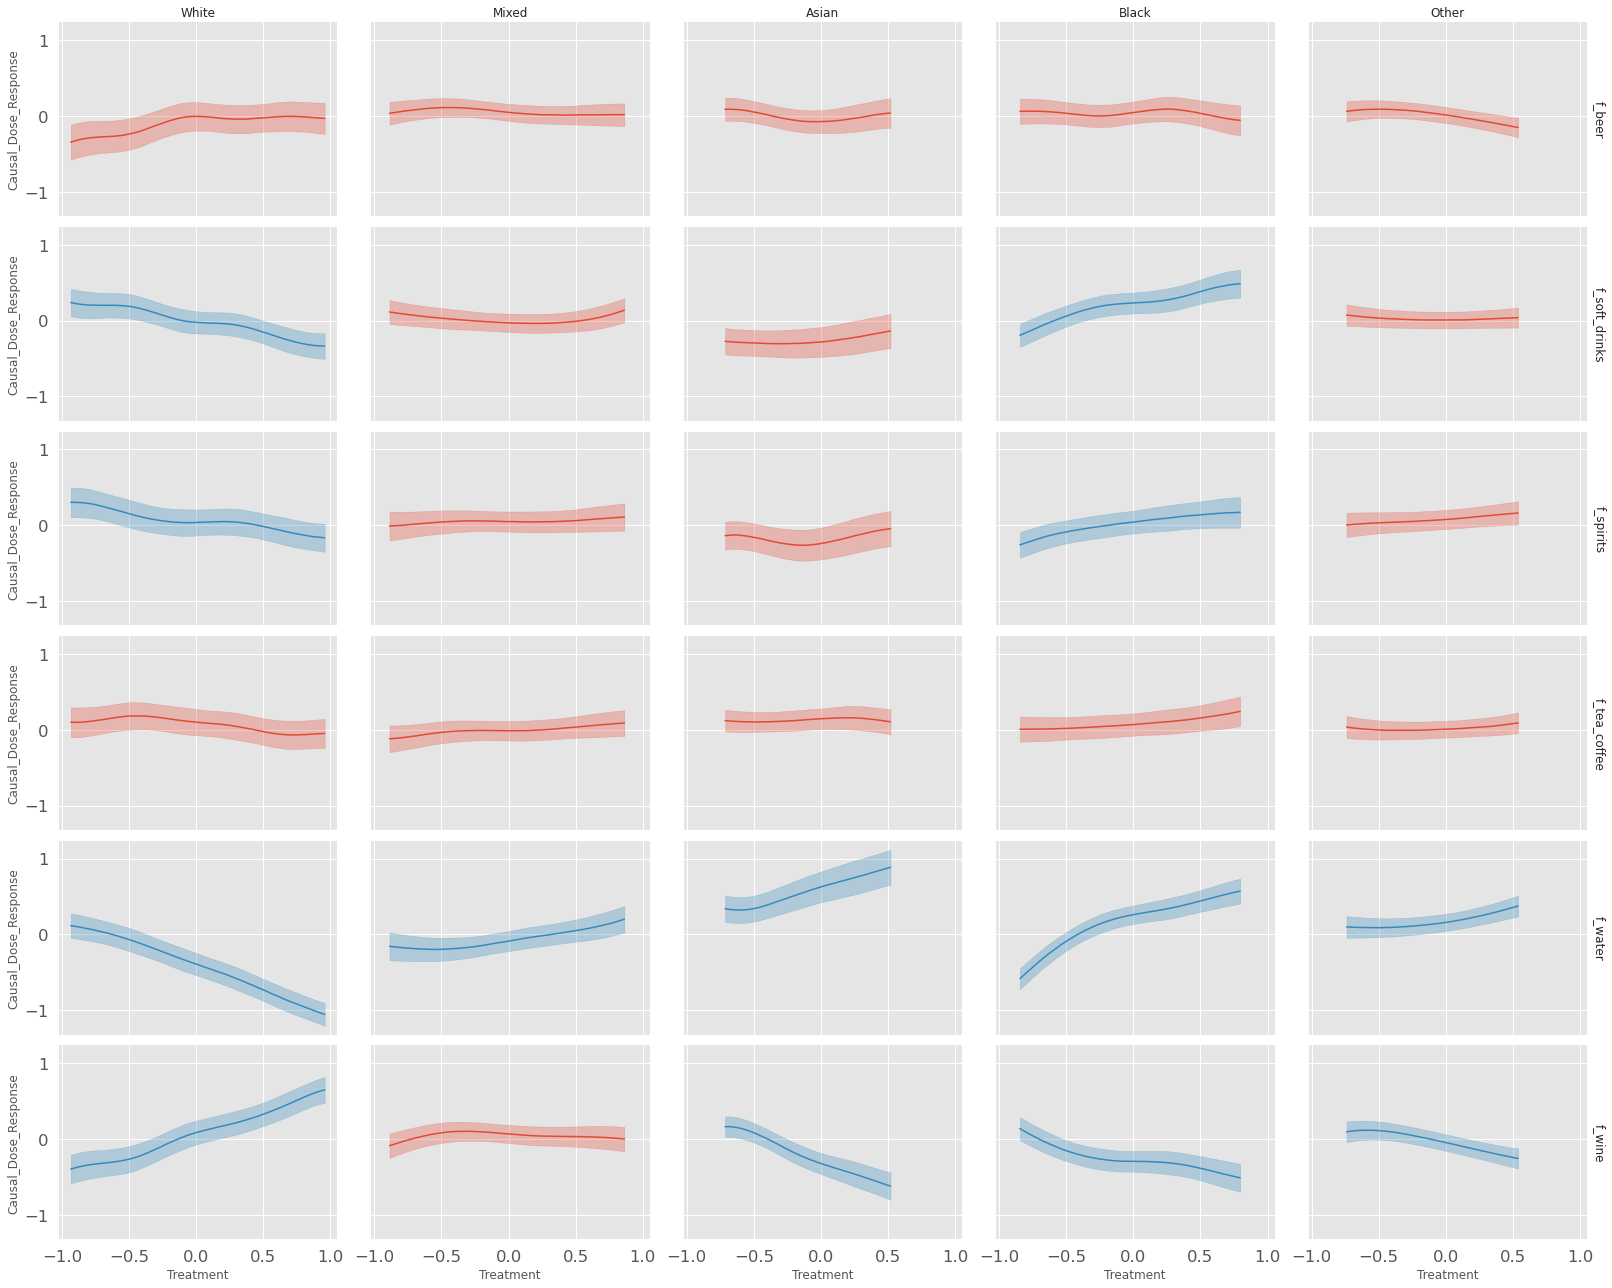

In [58]:
# with sns.plotting_context('paper', font_scale = 1.3):
p = sns.FacetGrid(caus_curve_drink_df,
                  row='outcome',
                  col='treatment',
                  hue='is_causal',
                  aspect=1.5,
                  margin_titles=True)
p.map(plt.fill_between, 'Treatment', 'Lower_CI', 'Upper_CI', alpha=.3)
p.map(plt.plot, 'Treatment', 'Causal_Dose_Response')
[plt.setp(ax.texts, text="") for ax in p.axes.flat] # remove the original texts
                                                    # important to add this before setting titles
p.set_titles(row_template = '{row_name}', col_template = '{col_name}')

## Visualizations for Data Story

#### Correlation bar plot

In [59]:
item_corr = np.concatenate((R_food_np, R_drink_np), axis=1)

ethnicities=['White', 'Mix. Eth.', 'Asian', 'Black', 'Oth. Eth. gr.']
food_it = ['Dairy', 'Eggs', 'Fats Oils', 'Fish', 'Fruit Veg.', 'Grains', 'Red Meat', 
           'Poultry', 'Ready made', 'Sauces', 'Sweets', 'Beer', 'Soft Drinks', 'Spirits',
           'Tea & Coffee', 'Water', 'Wine']

data = []

for i, eth in enumerate(ethnicities):
    colors = ['darkcyan' if val > 0 else 'crimson' for val in item_corr[i,:]]
    data.append(go.Bar(x=food_it, y=item_corr[i,:], name=eth, marker_color=colors,
                       visible=False))               

data[0]['visible'] = True

In [60]:
layout = go.Layout(yaxis_title="Spearman Rank Correlation",
                   xaxis_title="Tesco items",
                   title={'text': "Correlation between Ethnicity and Tesco items",
                          'y':0.9,
                          'x':0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'}
                  )

layout.update(updatemenus=list([
        dict(
            x=0.1,
            y=1.2,
            type = 'dropdown',
            visible = True,
            yanchor='top',
            buttons=list([
                dict(
                    args=['visible', [True, False, False, False, False]],
                    label='White',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, True, False, False, False]],
                    label='Mix. Eth.',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, True, False, False]],
                    label='Asian',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, True, False]],
                    label='Black',
                    method='restyle'
                )
                ,
                dict(
                    args=['visible', [False, False, False, False, True]],
                    label='Other Eth. gr.',
                    method='restyle'
                )
            ]),
        )]))
fig=go.Figure(data=data, layout =layout)
fig = fig.add_shape(type="line",
                    x0=10.5, y0=-0.7, x1=10.5, y1=0.7,
                    line=dict(color="lightslategrey",width=1)
                    )
fig = fig.add_shape(type="line",
                    x0=-0.5, y0=-0, x1=16.5, y1=0,
                    line=dict(color="lightslategrey",width=1.5)
                    )

fig.show()

In [61]:
item_corr = np.concatenate((R_food_np, R_drink_np), axis=1).T

data = []

for i, food in enumerate(food_it):
    colors = ['darkcyan' if val > 0 else 'crimson' for val in item_corr[i,:]]
    data.append(go.Bar(x=ethnicities, y=item_corr[i,:], name=food, marker_color=colors,
                       visible=False))               

data[0]['visible'] = True

In [62]:
layout = go.Layout(yaxis_title="Spearman Rank Correlation",
                   xaxis_title="Ethnicities",
                   title={'text': "Correlation between Ethnicity and Tesco items",
                          'y':0.9,
                          'x':0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'}
                  )

layout.update(updatemenus=list([
        dict(
            x=0.1,
            y=1.2,
            type = 'dropdown',
            visible = True,
            yanchor='top',
            buttons=list([
                dict(args=['visible', [True, False, False, False, False, False, False, False, False, 
                                       False, False, False, False, False, False, False, False]],
                    label='Dairy',method='restyle'),
                dict(args=['visible', [False, True, False, False, False, False, False, False, False, 
                                       False, False, False, False, False, False, False, False]],
                    label='Eggs',method='restyle'),
                dict(args=['visible', [False, False, True, False, False, False, False, False, False, 
                                       False, False, False, False, False, False, False, False]],
                    label='Fats Oils', method='restyle'),
                dict(args=['visible', [False, False, False, True, False, False, False, False, False, 
                                       False, False, False, False, False, False, False, False]],
                    label='Fish',method='restyle'),
                dict(args=['visible', [False, False, False, False, True, False, False, False, False, 
                                       False, False, False, False, False, False, False, False]],
                    label='Fruit Veg.', method='restyle'),
                dict(args=['visible', [False, False, False, False, False, True, False, False, False, 
                                       False, False, False, False, False, False, False, False]],
                    label='Grains',method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, True, False, False, 
                                       False, False, False, False, False, False, False, False]],
                    label='Red Meat', method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, True, False, 
                                       False, False, False, False, False, False, False, False]],
                    label='Poultry',method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, False, True, 
                                       False, False, False, False, False, False, False, False]],
                    label='Ready made', method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, False, False, 
                                       True, False, False, False, False, False, False, False]],
                    label='Sauces',method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, False, False, 
                                       False, True, False, False, False, False, False, False]],
                    label='Sweets', method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, False, False, 
                                       False, False, True, False, False, False, False, False]],
                    label='Beer',method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, False, False, 
                                       False, False, False, True, False, False, False, False]],
                    label='Soft Drinks', method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, False, False, 
                                       False, False, False, False, True, False, False, False]],
                    label='Spirits',method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, False, False, 
                                       False, False, False, False, False, True, False, False]],
                    label='Tea & Coffee', method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, False, False, 
                                       False, False, False, False, False, False, True, False]],
                    label='Water',method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, False, False, 
                                       False, False, False, False, False, False, False, True]],
                    label='Wine', method='restyle')
            ])
        )]))
fig=go.Figure(data=data, layout =layout)
fig = fig.add_shape(type="line",
                    x0=0.5, y0=-0.7, x1=0.5, y1=0.7,
                    line=dict(color="lightslategrey",width=0)
                    )
fig.show()

#### Map plots

In [63]:
def append_value(dict_obj, key, value):
    # Check if key exist in dict or not
    if key in dict_obj:
        # Key exist in dict.
        # Check if type of value of key is list or not
        if not isinstance(dict_obj[key], list):
            # If type is not list then make it list
            dict_obj[key] = [dict_obj[key]]
        # Append the value in list
        dict_obj[key].append(value)
    else:
        # As key is not in dict,
        # so, add key-value pair
        dict_obj[key] = value

In [64]:
import json

In [65]:
df = full_df

geojson_string = gpd.GeoSeries([df['geometry'][0]]).to_json()
# using json.loads() 
# convert dictionary string to dictionary 
res = json.loads(geojson_string)
res['features'][0]['id'] = df.index[0]

json_dict = res

for i in range(1, df.shape[0]):
    tmp_json_string = gpd.GeoSeries([df['geometry'][i]]).to_json()
    res = json.loads(tmp_json_string)
    res['features'][0]['id'] = df.index[i]
    geo_json = res['features'][0]
    append_value(json_dict, 'features', geo_json)

In [66]:
features = ['f_fruit_veg', 'f_dairy', 'f_grains', 'f_meat_red', 'f_poultry', 'f_eggs', 'f_fats_oils', 'f_fish',
            'f_readymade', 'f_sauces', 'f_sweets']
data = []

for feat in features:
    data.append(go.Choroplethmapbox(locations = df.index, 
                                    z = df[feat], 
                                    #text = feat, 
                                    colorbar = dict(thickness=20, ticklen=3),
                                    geojson=json_dict,
                                    colorscale = 'magma',
                                    name = feat,
                                    showlegend = True, 
                                    marker_line_width=1, 
                                    marker_opacity=0.9, 
                                    visible=False))
               
data[0]['visible'] = True

layout = go.Layout(height=500,
                   margin={"r":0,"t":0,"l":0,"b":0},
                   mapbox = dict(center= dict(lat=51.49, lon=-0.127),
                                 style="carto-positron", zoom=9))

layout.update(updatemenus=list([
        dict(
            x=0.2,
            y=1,
            #margin={"r":0,"t":0,"l":0,"b":0},
            #borderwidth = 0,
            type = 'dropdown',
            visible = True,
            yanchor='top',
            buttons=list([
                dict(
                    args=['visible', [True, False, False, False, False, False, False, False, False, False, False]],
                    label='Fruit Vegetables',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, True, False, False, False, False, False, False, False, False, False]],
                    label='Dairy',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, True, False, False, False, False, False, False, False, False]],
                    label='Grains',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, True, False, False, False, False, False, False, False]],
                    label='Red Meat',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, True, False, False, False, False, False, False]],
                    label='Poultry',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, True, False, False, False, False, False]],
                    label='Eggs',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, False, True, False, False, False, False]],
                    label='Fats Oil',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, False, False, True, False, False, False]],
                    label='Fish',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, False, False, False, True, False, False]],
                    label='Ready Made',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, False, False, False, False, True, False]],
                    label='Sauces',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, False, False, False, False, False, True]],
                    label='Sweets',
                    method='restyle'
                )
            ]),
        )]))
fig=go.Figure(data=data, layout =layout)
#fig.show()

In [67]:
features = ['f_wine', 'f_soft_drinks', 'f_spirits', 'f_tea_coffee', 'f_water', 'f_beer']
data = []

for feat in features:
    data.append(go.Choroplethmapbox(locations = df.index, 
                                    z = df[feat], 
                                    #text = feat, 
                                    colorbar = dict(thickness=20, ticklen=3),
                                    geojson=json_dict,
                                    colorscale = 'magma',
                                    name = feat,
                                    showlegend = True, 
                                    marker_line_width=1, 
                                    marker_opacity=0.9, 
                                    visible=False))
               
data[0]['visible'] = True

layout = go.Layout(height=500,
                   margin={"r":0,"t":0,"l":0,"b":0},
                   mapbox = dict(center= dict(lat=51.49, lon=-0.127),
                                 style="carto-positron", zoom=9))

layout.update(updatemenus=list([
        dict(
            x=0.2,
            y=1,
            #margin={"r":0,"t":0,"l":0,"b":0},
            #borderwidth = 0,
            type = 'dropdown',
            visible = True,
            yanchor='top',
            buttons=list([
                dict(
                    args=['visible', [True, False, False, False, False, False]],
                    label='Wine',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, True, False, False, False, False]],
                    label='Soft Drinks',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, True, False, False, False]],
                    label='Spirits',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, True, False, False]],
                    label='Tea & Coffee',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, True, False]],
                    label='Water',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, True]],
                    label='Beer',
                    method='restyle'
                )
            ]),
        )]))
fig=go.Figure(data=data, layout =layout)
#fig.show()

In [68]:
feats = ['Ethnic_Group;White_(ratio);2011',
         'Ethnic_Group;Mixed/multiple_ethnic_groups_(ratio);2011',
         'Ethnic_Group;Asian/Asian_British_(ratio);2011',
         'Ethnic_Group;Black/African/Caribbean/Black_British_(ratio);2011',
         'Ethnic_Group;Other_ethnic_group_(ratio);2011']

eth_df = df[feats]
eth_df.columns = ['White(%)', 'Mixed Eth.(%)', 'Asian(%)', 'Black(%)', 'Oth. Eth. Gr.(%)']

features = eth_df.columns
data = []

for feat in features:
    data.append(go.Choroplethmapbox(locations = df.index, 
                                    z = eth_df[feat], 
                                    #text = feat, 
                                    colorbar = dict(thickness=20, ticklen=3),
                                    geojson=json_dict,
                                    colorscale = 'magma',
                                    name = feat,
                                    showlegend = True, 
                                    marker_line_width=1, 
                                    marker_opacity=0.9, 
                                    visible=False))
               
data[0]['visible'] = True

layout = go.Layout(height=500,
                   margin={"r":0,"t":0,"l":0,"b":0},
                   mapbox = dict(center= dict(lat=51.49, lon=-0.127),
                                 style="carto-positron", zoom=9))

layout.update(updatemenus=list([
        dict(
            x=0.2,
            y=1,
            #margin={"r":0,"t":0,"l":0,"b":0},
            #borderwidth = 0,
            type = 'dropdown',
            visible = True,
            yanchor='top',
            buttons=list([
                dict(
                    args=['visible', [True, False, False, False, False]],
                    label='White',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, True, False, False, False]],
                    label='Mixed Eth.',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, True, False, False]],
                    label='Asian',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, True, False]],
                    label='Black',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, True]],
                    label='Other Eth. Gr.',
                    method='restyle'
                )
            ]),
        )]))
fig=go.Figure(data=data, layout =layout)
#fig.show()

#### Paircat plot

In [69]:
employ = full_df['Economic_Activity;Employment_ratio;2011']
salary = full_df['Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)']
items_entropy = full_df['h_items_norm']
avg_age = full_df['avg_age']
h_ethnicity = full_df['Ethnic_Group;h_ethnicities_norm;2011']

In [70]:
# Create dimensions
rich_cat_feat = pd.cut(salary, bins=np.quantile(salary, [0, 0.1, 0.25, 0.75, 0.9, 1]), labels=[0,1,2,3,4],
                       include_lowest=True)

rich_dim = go.parcats.Dimension(values=rich_cat_feat, label="Richness of the area",
                                categoryarray=[0, 1, 2, 3, 4], 
                                ticktext=["very poor", "poor", "medium", "rich", "very rich"])

employ_cat_feat = pd.cut(employ, bins=[0, 50, 60, 70, 80, 100], labels=[0,1,2,3,4],
                         include_lowest=True)

employ_dim = go.parcats.Dimension(values=employ_cat_feat, label="Employment rate",
                                  categoryarray=[0, 1, 2, 3, 4], 
                                  ticktext=['0 to 50%', '50 to 60%', '60 to 70%', '70 to 80%', '80 to 100%'])

age_cat_feat = pd.cut(avg_age, bins=[25, 30, 35, 40, 45, 60], labels=[0,1,2,3,4],
                      include_lowest=True)

age_dim = go.parcats.Dimension(values=age_cat_feat, label="Avg. Age of the area",
                               categoryarray=[0, 1, 2, 3, 4], 
                               ticktext=['25 to 30', '30 to 35', '35 to 40', '40 to 45', '45 to 60'])

hitems_cat_feat = pd.cut(items_entropy, bins=np.quantile(items_entropy, [0, 0.1, 0.25, 0.75, 0.9, 1]),
                         labels=["very similar", "similar", 'medium', "diverse", "very diverse"], 
                         include_lowest=True)

hitems_dim = go.parcats.Dimension(values=hitems_cat_feat, label="Food Purchase Diversity of the area")

h_ethnicity_cat_feat = pd.cut(h_ethnicity, bins=np.quantile(h_ethnicity, [0, 0.1, 0.25, 0.75, 0.9, 1]),
                                  labels=["very similar", "similar", "medium", "diverse", "very diverse"],
                                  include_lowest=True)

h_ethnicity_dim = go.parcats.Dimension(values=h_ethnicity_cat_feat, label="Ethnicity Diversity of the area")


# Create parcats trace
#color = df_cat.Ethnicity_entropy;
color = rich_cat_feat;
color2 = employ_cat_feat;
color3 = age_cat_feat;
colorscale = px.colors.sequential.Inferno;
#[[0, 'aliceblue'], [1, 'limegreen']];

data = [go.Parcats(dimensions=[hitems_dim, rich_dim, h_ethnicity_dim],
                                   line={'color': color, 'colorscale': colorscale},
                                   hoveron='color', hoverinfo='count+probability',
                                   labelfont={'size': 14, 'family': 'Times'},
                                   tickfont={'size': 12, 'family': 'Times'},
                                   arrangement='freeform', visible=True),
        go.Parcats(dimensions=[hitems_dim, employ_dim, h_ethnicity_dim],
                   line={'color': color2, 'colorscale': colorscale},
                   hoveron='color', hoverinfo='count+probability',
                   labelfont={'size': 14, 'family': 'Times'},
                   tickfont={'size': 12, 'family': 'Times'},
                   arrangement='freeform', visible=False),
        go.Parcats(dimensions=[hitems_dim, age_dim, h_ethnicity_dim],
                   line={'color': color3, 'colorscale': colorscale},
                   hoveron='color', hoverinfo='count+probability',
                   labelfont={'size': 14, 'family': 'Times'},
                   tickfont={'size': 12, 'family': 'Times'},
                   arrangement='freeform', visible=False)
       ]

layout = go.Layout()

layout.update(updatemenus=list([
        dict(
            x=0.1,
            y=1.2,
            type = 'dropdown',
            visible = True,
            yanchor='top',
            buttons=list([
                dict(
                    args=['visible', [True, False, False]],
                    label='Richness',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, True, False]],
                    label='Employment Rate',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, True]],
                    label='Avg. Age',
                    method='restyle'
                )
            ]),
        )]))
fig=go.Figure(data=data, layout =layout)

fig.show()

#### Linear regression plot

In [71]:
pred_list = []
r2_list = []

#########
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df['h_ethnicity'],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsres = sm.OLS(y_train, X_train).fit()
pred_list.append(olsres.predict(X_test))
r2_list.append(olsres.rsquared)
#########
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df['employment_rate'],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsres = sm.OLS(y_train, X_train).fit()
pred_list.append(olsres.predict(X_test))
r2_list.append(olsres.rsquared)
#########
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df['avg_age'],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsres = sm.OLS(y_train, X_train).fit()
pred_list.append(olsres.predict(X_test))
r2_list.append(olsres.rsquared)
#########
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df['median_household_income'],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsres = sm.OLS(y_train, X_train).fit()
pred_list.append(olsres.predict(X_test))
r2_list.append(olsres.rsquared)
#########
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df[['h_ethnicity', 'employment_rate']],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsres = sm.OLS(y_train, X_train).fit()
pred_list.append(olsres.predict(X_test))
r2_list.append(olsres.rsquared)
#########
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df[['h_ethnicity', 'avg_age']],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsres = sm.OLS(y_train, X_train).fit()
pred_list.append(olsres.predict(X_test))
r2_list.append(olsres.rsquared)
#########
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df[['h_ethnicity', 'median_household_income']],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsres = sm.OLS(y_train, X_train).fit()
pred_list.append(olsres.predict(X_test))
r2_list.append(olsres.rsquared)
#########
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df[['h_ethnicity', 'avg_age', 
                                                                'median_household_income', 'employment_rate']],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsres = sm.OLS(y_train, X_train).fit()
pred_list.append(olsres.predict(X_test))
r2_list.append(olsres.rsquared)
#########
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df[['avg_age','median_household_income', 'employment_rate']],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsres = sm.OLS(y_train, X_train).fit()
pred_list.append(olsres.predict(X_test))
r2_list.append(olsres.rsquared)

In [72]:
from plotly.offline import init_notebook_mode, iplot, plot
from plotly import tools
from plotly.subplots import make_subplots

In [73]:
### Create individual figures
# START
fig = tools.make_subplots(rows=1, cols=2, column_widths=[0.7, 0.3], 
                          subplot_titles=('Regression prediction',  'Variance Explained'))

trace1 = go.Scatter(x = y_test, y = pred_list[0], mode = 'markers', showlegend=False, visible=True, marker=dict(size=3))
trace2 = go.Scatter(x = y_test, y = pred_list[1], mode = 'markers', showlegend=False, visible=False, marker=dict(size=3))
trace3 = go.Scatter(x = y_test, y = pred_list[2], mode = 'markers', showlegend=False, visible=False, marker=dict(size=3))
trace4 = go.Scatter(x = y_test, y = pred_list[3], mode = 'markers', showlegend=False, visible=False, marker=dict(size=3))
trace5 = go.Scatter(x = y_test, y = pred_list[4], mode = 'markers', showlegend=False, visible=False, marker=dict(size=3))
trace6 = go.Scatter(x = y_test, y = pred_list[5], mode = 'markers', showlegend=False, visible=False, marker=dict(size=3))
trace7 = go.Scatter(x = y_test, y = pred_list[6], mode = 'markers', showlegend=False, visible=False, marker=dict(size=3))
trace8 = go.Scatter(x = y_test, y = pred_list[7], mode = 'markers', showlegend=False, visible=False, marker=dict(size=3))
trace9 = go.Scatter(x = y_test, y = pred_list[8], mode = 'markers', showlegend=False, visible=False, marker=dict(size=3))

fig.append_trace(trace1, 1, 1)
fig.update_layout(yaxis_range=[-6,3], xaxis_range=[-6,3])
fig.append_trace(trace2, 1, 1)
fig.append_trace(trace3, 1, 1)
fig.append_trace(trace4, 1, 1)
fig.append_trace(trace5, 1, 1)
fig.append_trace(trace6, 1, 1)
fig.append_trace(trace7, 1, 1)
fig.append_trace(trace8, 1, 1)
fig.append_trace(trace9, 1, 1)

trace11 = go.Bar(x=['R2 diversity ethnicity', 'R2 Model'], y=[r2_list[0],r2_list[0]],
                width=0.2, showlegend=False, visible=True)
trace12 = go.Bar(x=['R2 diversity ethnicity', 'R2 Model'], y=[r2_list[0],r2_list[1]],
                width=0.2, showlegend=False, visible=False)
trace13 = go.Bar(x=['R2 diversity ethnicity', 'R2 Model'], y=[r2_list[0],r2_list[2]],
                width=0.2, showlegend=False, visible=False)
trace14 = go.Bar(x=['R2 diversity ethnicity', 'R2 Model'], y=[r2_list[0],r2_list[3]],
                width=0.2, showlegend=False, visible=False)
trace15 = go.Bar(x=['R2 diversity ethnicity', 'R2 Model'], y=[r2_list[0],r2_list[4]],
                width=0.2, showlegend=False, visible=False)
trace16 = go.Bar(x=['R2 diversity ethnicity', 'R2 Model'], y=[r2_list[0],r2_list[5]],
                width=0.2, showlegend=False, visible=False)
trace17 = go.Bar(x=['R2 diversity ethnicity', 'R2 Model'], y=[r2_list[0],r2_list[6]],
                width=0.2, showlegend=False, visible=False)
trace18 = go.Bar(x=['R2 diversity ethnicity', 'R2 Model'], y=[r2_list[0],r2_list[7]],
                width=0.2, showlegend=False, visible=False)
trace19 = go.Bar(x=['R2 diversity ethnicity', 'R2 Model'], y=[r2_list[0],r2_list[8]],
                width=0.2, showlegend=False, visible=False)

fig.append_trace(trace11, 1, 2)
fig.append_trace(trace12, 1, 2)
fig.append_trace(trace13, 1, 2)
fig.append_trace(trace14, 1, 2)
fig.append_trace(trace15, 1, 2)
fig.append_trace(trace16, 1, 2)
fig.append_trace(trace17, 1, 2)
fig.append_trace(trace18, 1, 2)
fig.append_trace(trace19, 1, 2)
# END

### Create buttons for drop down menu
labels=['Div. Eth.', 'Employ. Rate', 'Avg. Age', 'Med. Income', 'Eth. + Employ.', 'Eth. + Age', 'Eth. + Income',
        'Eth. + Employ. + Age + Inc.', 'Employ. + Age + Inc.']
buttons = []
for i, label in enumerate(labels):
    visibility = [i==j for j in range(len(labels))]
    button = dict(
                 label =  label,
                 method = 'update',
                 args = [{'visible': visibility},
                     #{'title': label}
                        ])
    buttons.append(button)

updatemenus = list([
    dict(active=0,
         x=0.1,
         y=1.2,
         buttons=buttons
    )
])

fig['layout']['title'] = {'text': "Regression Analysis",
                          'y':0.95,
                          'x':0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'}
fig['layout']['showlegend'] = True
fig['layout']['updatemenus'] = updatemenus
# edit axis labels
fig['layout']['xaxis']['title']='True items diversity'
fig['layout']['yaxis']['title']='Predicted items diversity'
#fig['layout']['yaxis2']['title']='Variance Explained'
fig['layout']['yaxis2']['range']=[0,0.2]

iplot(fig, filename='dropdown')

/home/maxime/anaconda3/envs/ada/lib/python3.8/site-packages/plotly/tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [74]:
col_causal = ['aliceblue' if met < 0 else 'lightpink' for met in caus_metric]

fig = go.Figure(data=[go.Table(
    columnwidth = [400,80,80],
    header=dict(values=list(sort_df.columns[0:5]),
                #fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[sort_df.feature, sort_df.correlation, 
                       sort_df.caus_metric, sort_df.corr_rank, sort_df.caus_rank],
               line_color=[col_causal], fill_color=[col_causal],
               #fill_color='lavender',
               align='left'))
])

fig.show()